## Imports

In [151]:
import os
import random

import numpy as np
import pandas as pd
import scipy.io as sio # for loading MATLAB files
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, welch, resample, hilbert
from scipy.stats import mode

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, SelectPercentile, chi2

## Functions

In [152]:
# Action1 + Action2 -> Gesture
def compute_flat_label(row):
    if pd.isna(row['Action2']): # if Action2 is NaN, return Action1
        return row['Action1']
    else:
        return row['Action2']
    
# Downsample dataframe
def downsample_dataframe_with_labels(df, target_freq, time_col='Timestamp', label_cols=None, method='resample'):
    """
    Downsamples a DataFrame with timestamp, signal columns, and optional label columns.
    
    Parameters:
        df : pd.DataFrame
            Input data (must include a time column).
        target_freq : int
            Target sampling frequency in Hz.
        time_col : str
            Name of the time column.
        label_cols : list of str
            Columns with categorical labels (e.g., ['FlatLabel', 'Action1', 'Action2']).
        method : str
            'resample' (FFT-based) or 'average' (bin-average + mode for labels).
    
    Returns:
        pd.DataFrame
            Downsampled DataFrame with aligned time, signal, and label columns.
    """
    if time_col not in df.columns:
        raise ValueError(f"{time_col} must be in dataframe")

    label_cols = label_cols or []
    all_cols = df.columns.tolist()
    signal_cols = [col for col in all_cols if col not in [time_col] + label_cols]

    t_orig = df[time_col].values
    t_start, t_end = t_orig[0], t_orig[-1]
    duration = t_end - t_start
    n_target = int(duration * target_freq)

    # Downsample signals
    if method == 'resample':
        signals_ds = pd.DataFrame(
            resample(df[signal_cols].values, n_target),
            columns=signal_cols
        )
    elif method == 'average':
        df_indexed = df.set_index(time_col)
        df_indexed.index = pd.to_datetime(df_indexed.index, unit='s')
        signals_ds = df_indexed[signal_cols].resample(f"{int(1000/target_freq)}ms").mean().dropna().reset_index(drop=True)
    else:
        raise ValueError("method must be 'resample' or 'average'")

    # Generate new time vector
    t_uniform = np.linspace(t_start, t_end, n_target, endpoint=False)
    signals_ds.insert(0, time_col, t_uniform)

    # Downsample labels using mode per time bin
    if label_cols:
        df_label = df[[time_col] + label_cols].copy()
        df_label.index = pd.to_datetime(df_label[time_col], unit='s')

        bin_size_ms = int(1000 / target_freq)
        label_resampled = []

        for col in label_cols:
            grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan  # Handle empty mode
            )
            grouped = grouped.fillna(method='ffill')  # Forward-fill NaN values
            label_resampled.append(grouped)

        label_df = pd.concat(label_resampled, axis=1)
        label_df.columns = label_cols
        label_df = label_df.dropna().reset_index(drop=True)

        # Align label_df to signal df
        label_df = label_df.iloc[:len(signals_ds)]
        signals_ds[label_cols] = label_df

    return signals_ds

# Filter
def hampel_filter(series, window_size=3, n_sigmas=3):
    """Applies Hampel filter to a 1D pandas Series."""
    L = 1.4826  # scale factor for Gaussian distribution
    rolling_median = series.rolling(window=2 * window_size + 1, center=True).median()
    diff = np.abs(series - rolling_median)
    mad = L * diff.rolling(window=2 * window_size + 1, center=True).median()
    
    # Identify outliers
    outlier_idx = diff > n_sigmas * mad
    filtered = series.copy()
    filtered[outlier_idx] = rolling_median[outlier_idx]
    return filtered

# Clean data
def clean_data(raw_data):
    cleaned_data = raw_data.copy()
    
    # Remove the first row
    cleaned_data = cleaned_data.drop(index=0)

    # Number of channels
    num_channels = 2

    # Compute the average sampling frequency and jitter
    sampling_freq = 1 / np.mean(np.diff(cleaned_data["Timestamp"]))
    jitter = np.mean(np.diff(cleaned_data["Timestamp"]))
    # print(f"Sampling Frequency: {sampling_freq} Hz")
    # print(f"Jitter: {jitter} seconds")

    for i in range(num_channels): # nb of channels
        channel = cleaned_data["Channel{}".format(i+1)]

        # Remove DC offset
        channel = (channel - np.mean(channel))

        # Filter 50Hz noise using a Hampel filter
        # channel = hampel_filter(channel, window_size=300, n_sigmas=3)

        cleaned_data["Channel{}".format(i+1)] = channel
    
    return cleaned_data

# Extract features
def extract_features_and_labels(data, features, label_column = 'Gesture', window=200, step_size=50):
    X = data.copy()
    X.drop(columns=['Gesture', 'Timestamp'], inplace=True)
    if 'Repetition' in X.columns:
        X.drop(columns=['Repetition'], inplace=True)
    if 'Rest' in X.columns:
        X.drop(columns=['Rest'], inplace=True)
    y = data[label_column]
    
    features_list = []
    labels_list = []

    for i in range(0, len(data) - window + 1, step_size):
        window_data = data.iloc[i:i + window]

        # analytic_signal = hilbert(data_npulse_filtered['Channel1'])
        # envelope = np.abs(analytic_signal)

        envelope_data = pd.DataFrame()
        for channel in X.columns:
            envelope_data[channel] = np.abs(hilbert(window_data[channel].values))

        feature_vector = [feature(envelope_data[channel].values) for channel in X.columns for feature in features]
        # feature_vector = [feature(window_data[channel].values) for channel in X.columns for feature in features]

        features_list.append(feature_vector)
        labels_list.append(window_data[label_column].values[0])
    
    return np.array(features_list), np.array(labels_list)


# Balance dataset
def balance_rest(df, label_col='Gesture', rest_label='Rest', target_rest_ratio=0.5):
    """
    Reduces the amount of 'Rest' class to balance dataset.
    
    Parameters:
        df : pd.DataFrame
            Input dataframe with labels
        label_col : str
            Name of label column
        rest_label : str
            The label value corresponding to Rest
        target_rest_ratio : float
            Target fraction of Rest samples after balancing (e.g., 0.5 = 50% of dataset)

    Returns:
        pd.DataFrame
            Balanced dataframe
    """
    rest_df = df[df[label_col] == rest_label]
    gesture_df = df[df[label_col] != rest_label]

    n_gesture = len(gesture_df)
    n_target_rest = int(n_gesture * target_rest_ratio / (1 - target_rest_ratio))

    if n_target_rest > len(rest_df):
        print("Warning: not enough Rest samples to achieve target ratio.")
        return df

    rest_sampled = rest_df.sample(n=n_target_rest, random_state=42)

    balanced_df = pd.concat([rest_sampled, gesture_df]).sort_index()
    return balanced_df


## Global variables

In [153]:
# Gesture IDs
id_to_gesture = {
    0: "Rest",
    1: "ThumbUp",
    2: "Scisors",
    5: "Palm",
    6: "Fist",
    9: "WristRotIn",
    10: "WristRotExt",
    13: "WristFlexion",
    14: "WristExt",
}

# npulse_gestures = {"Rest", "Fist", "WristFlexion", "WristExt", "WristRotIn", "WristRotExt", "Palm"}
npulse_gestures = {"Rest", "Fist"}

gesture_to_id = {v: k for k, v in id_to_gesture.items() if v in npulse_gestures}

In [154]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Variance
var = lambda x: np.var(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1] * np.diff(x, axis=0)[1:]) < 0, axis=0)
# Zero Crossing (ZC)
def zero_crossing(x):
    return np.sum(np.diff(np.sign(x), axis=0) != 0)
zc = lambda x: zero_crossing(x)
# Log detector
log_det = lambda x: np.exp(1/len(x) * np.sum(np.log(x), axis=0))
# Willison amplitude
wamp = lambda x: np.sum((x > 0.2*std(x)), axis=0)

# Frequency domain features (FFT-based)
fft_values = lambda x: np.fft.fft(x, axis=0)
fft_magnitude = lambda x: np.abs(fft_values(x))
fft_power = lambda x: np.square(fft_magnitude(x))
freqs = lambda x: np.fft.fftfreq(x.shape[0], d=1/1000)  # Assuming a sampling rate of 1000 Hz
# Total power
total_power = lambda x: np.sum(fft_power(x), axis=0)  
# Mean frequency
mean_freq = lambda x: np.sum(freqs(x) * fft_power(x), axis=0) / np.sum(fft_power(x), axis=0) 
# Median frequency
median_freq = lambda x: np.median(freqs(x) * fft_power(x), axis=0) 
# Peak frequency 
peak_freq = lambda x: freqs(x)[np.argmax(fft_power(x), axis=0)]  

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)

features_selected = [total_power, mav, rms, mean_freq]

# select all features
features_selected = [
    total_power, mav, std, var, maxav, rms, wl, ssc, zc, log_det, wamp,
    mean_freq, median_freq, peak_freq
]

In [155]:
# Mean absolute value (MAV)
def mav(x):
    return np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
def std(x):
    return np.std(x, axis=0)

# Variance
def var(x):
    return np.var(x, axis=0)

# Maximum absolute Value (MaxAV)
def maxav(x):
    return np.max(np.abs(x), axis=0)

# Root mean square (RMS)
def rms(x):
    return np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
def wl(x):
    return np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope sign changes (SSC)
def ssc(x):
    return np.sum((np.diff(x, axis=0)[:-1] * np.diff(x, axis=0)[1:]) < 0, axis=0)

# Zero Crossing (ZC)
def zc(x):
    return np.sum(np.diff(np.sign(x), axis=0) != 0)

# Log detector
def log_det(x):
    return np.exp(1 / len(x) * np.sum(np.log(x), axis=0))

# Willison amplitude
def wamp(x):
    return np.sum((x > 0.2 * np.std(x)), axis=0)

# Frequency domain features (FFT-based)
def fft_values(x):
    return np.fft.fft(x, axis=0)

def fft_magnitude(x):
    return np.abs(fft_values(x))

def fft_power(x):
    return np.square(fft_magnitude(x))

def freqs(x):
    return np.fft.fftfreq(x.shape[0], d=1/1000)  # Assuming a sampling rate of 1000 Hz

# Total power
def total_power(x):
    return np.sum(fft_power(x), axis=0)

# Mean frequency
def mean_freq(x):
    return np.sum(freqs(x) * fft_power(x), axis=0) / np.sum(fft_power(x), axis=0)

# Median frequency
def median_freq(x):
    return np.median(freqs(x) * fft_power(x), axis=0)

# Peak frequency
def peak_freq(x):
    return freqs(x)[np.argmax(fft_power(x), axis=0)]

## Loading npulse raw data

In [156]:
raw_npulse_data_path = os.path.join("data", "npulse", "raw")

for root, d_names, f_names in os.walk(raw_npulse_data_path):
    print('File names:', f_names)

list_npulse_data = {}
for file in f_names:
    if "_5_" in file:
        print(f"Loading {file}...")
        raw_data = pd.read_csv(os.path.join(raw_npulse_data_path, file))
        list_npulse_data[file] = raw_data

File names: ['MF_L_5_250509111424.csv', 'MF_L_5_250509111622.csv', 'MF_L_5_250509111711.csv', 'MF_L_5_250509111828.csv', 'MF_L_5_250509111932.csv', 'WS_R_4_250328161002.csv', 'WS_R_4_250328161356.csv', 'WS_R_4_250328161516.csv', 'WS_R_4_250328161630.csv', 'WS_R_4_250328161835.csv', 'WS_R_4_250328161941.csv', 'WS_R_4_250328162058.csv', 'WS_R_4_250328162840.csv', 'WS_R_4_250328163057.csv', 'WS_R_4_250328163152.csv', 'WS_R_4_250328164449.csv', 'WS_R_4_250328164936.csv', 'WS_R_4_250328165059.csv', 'WS_R_4_250328165201.csv', 'WS_R_5_250509100145.csv', 'WS_R_5_250509100340.csv', 'WS_R_5_250509100435.csv', 'WS_R_5_250509100529.csv', 'WS_R_5_250509100714.csv']
Loading MF_L_5_250509111424.csv...
Loading MF_L_5_250509111622.csv...
Loading MF_L_5_250509111711.csv...
Loading MF_L_5_250509111828.csv...
Loading MF_L_5_250509111932.csv...
Loading WS_R_5_250509100145.csv...
Loading WS_R_5_250509100340.csv...
Loading WS_R_5_250509100435.csv...
Loading WS_R_5_250509100529.csv...
Loading WS_R_5_250509100

In [157]:
# list_npulse_data[0].head(5)  # Display the first 5 rows of the first file

## Prepare data

In [158]:
list_npulse_cleaned_data = {}

for name, raw_data in list_npulse_data.items():
    # Print iteration
    print(f"Processing file: {len(list_npulse_cleaned_data) + 1} / {len(list_npulse_data)}")

    # Clean
    cleaned_data = clean_data(raw_data)

    # Envelope
    # envelope_data = cleaned_data.copy()
    # for channel in raw_data.drop(columns=['Timestamp','Action1','Action2']).columns:  # Exclude 'Timestamp', 'Gesture', and 'Repetition'
    #     envelope_data[channel] = np.abs(hilbert(cleaned_data[channel].values))

    # Gesture column + gesture to ID
    data = cleaned_data.copy()
    data['Gesture'] = data.apply(compute_flat_label, axis=1)
    data['Gesture'] = data['Gesture'].map(gesture_to_id)
    data.drop(columns=['Action1', 'Action2'], inplace=True) 
    downsampled_data = data.copy()

    # # Downsample
    # target_freq = 1000  # Target frequency in Hz
    # downsampled_data = downsample_dataframe_with_labels(data, target_freq, time_col='Timestamp', label_cols=['Gesture'], method='resample')
    # downsampled_data['Gesture'] = downsampled_data['Gesture'].astype(int) 


    # SNR normalization ?

    list_npulse_cleaned_data[name] = downsampled_data

Processing file: 1 / 10
Processing file: 2 / 10
Processing file: 3 / 10
Processing file: 4 / 10
Processing file: 5 / 10
Processing file: 6 / 10
Processing file: 7 / 10
Processing file: 8 / 10
Processing file: 9 / 10
Processing file: 10 / 10


## Saving / loading npulse cleaned data

In [159]:
# Saving the cleaned data
npulse_cleaned_data_path = os.path.join("data", "npulse", "cleaned")
os.makedirs(npulse_cleaned_data_path, exist_ok=True)

for name, data in list_npulse_cleaned_data.items():
    file_name = os.path.splitext(name)[0] + "_cleaned.csv"
    data.to_csv(os.path.join(npulse_cleaned_data_path, file_name), index=False)
    print(f"Saved {file_name} to {npulse_cleaned_data_path}")
    

Saved MF_L_5_250509111424_cleaned.csv to data\npulse\cleaned
Saved MF_L_5_250509111622_cleaned.csv to data\npulse\cleaned
Saved MF_L_5_250509111711_cleaned.csv to data\npulse\cleaned
Saved MF_L_5_250509111828_cleaned.csv to data\npulse\cleaned
Saved MF_L_5_250509111932_cleaned.csv to data\npulse\cleaned
Saved WS_R_5_250509100145_cleaned.csv to data\npulse\cleaned
Saved WS_R_5_250509100340_cleaned.csv to data\npulse\cleaned
Saved WS_R_5_250509100435_cleaned.csv to data\npulse\cleaned
Saved WS_R_5_250509100529_cleaned.csv to data\npulse\cleaned
Saved WS_R_5_250509100714_cleaned.csv to data\npulse\cleaned


In [160]:
# Loading the cleaned data
list_npulse_cleaned_data = []

for root, d_names, f_names in os.walk(npulse_cleaned_data_path):
    print('File names:', f_names)

for file in f_names:
    if "_5_" in file:
        cleaned_data = pd.read_csv(os.path.join(npulse_cleaned_data_path, file))
        list_npulse_cleaned_data.append(cleaned_data)

# Loading the raw data
list_npulse_raw_data = []
for key, data in list_npulse_data.items():
    data_ = data.fillna("None")
    list_npulse_raw_data.append(data_)


File names: ['MF_L_5_250509111424_cleaned.csv', 'MF_L_5_250509111622_cleaned.csv', 'MF_L_5_250509111711_cleaned.csv', 'MF_L_5_250509111828_cleaned.csv', 'MF_L_5_250509111932_cleaned.csv', 'WS_R_4_250328161002_cleaned.csv', 'WS_R_4_250328161356_cleaned.csv', 'WS_R_4_250328161516_cleaned.csv', 'WS_R_4_250328161630_cleaned.csv', 'WS_R_4_250328161835_cleaned.csv', 'WS_R_4_250328161941_cleaned.csv', 'WS_R_4_250328162058_cleaned.csv', 'WS_R_4_250328162840_cleaned.csv', 'WS_R_4_250328163057_cleaned.csv', 'WS_R_4_250328163152_cleaned.csv', 'WS_R_4_250328164449_cleaned.csv', 'WS_R_4_250328164936_cleaned.csv', 'WS_R_4_250328165059_cleaned.csv', 'WS_R_4_250328165201_cleaned.csv', 'WS_R_5_250509100145_cleaned.csv', 'WS_R_5_250509100340_cleaned.csv', 'WS_R_5_250509100435_cleaned.csv', 'WS_R_5_250509100529_cleaned.csv', 'WS_R_5_250509100714_cleaned.csv']


## Plotting data

In [161]:
# # Plot all data with 3 subplots on the same line
# for i, data in enumerate(list_npulse_cleaned_data):
#     plt.figure(figsize=(18, 6))  # Adjust the figure size for 3 subplots

#     # Plot Channel 1
#     plt.subplot(1, 3, 1)
#     plt.plot(data['Timestamp'], data['Channel1'], label='Channel 1', color='blue')
#     plt.title(f'Channel 1 - File {i+1}')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')
#     plt.legend()
#     plt.grid()

#     # Plot Channel 2
#     plt.subplot(1, 3, 2)
#     plt.plot(data['Timestamp'], data['Channel2'], label='Channel 2', color='orange')
#     plt.title(f'Channel 2 - File {i+1}')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')
#     plt.legend()
#     plt.grid()

#     # Plot Gesture
#     plt.subplot(1, 3, 3)
#     plt.plot(data['Timestamp'], data['Gesture'], label='Gesture', color='green', alpha=0.5)
#     plt.title(f'Gesture - File {i+1}')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Gesture')
#     plt.legend()
#     plt.grid()

#     # Show the figure
#     plt.tight_layout()
#     plt.show()

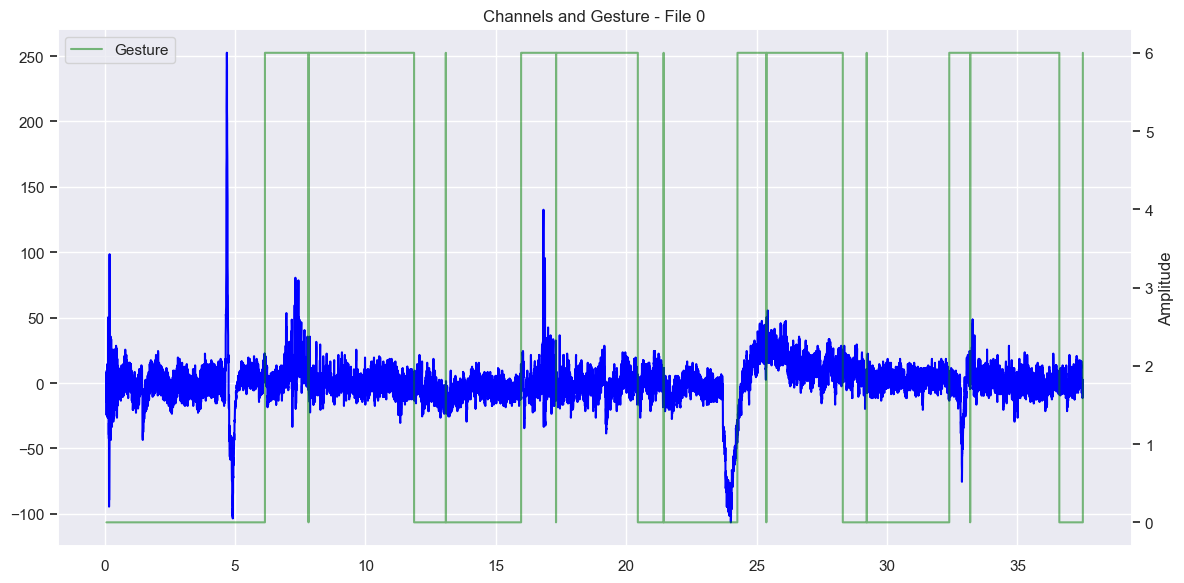

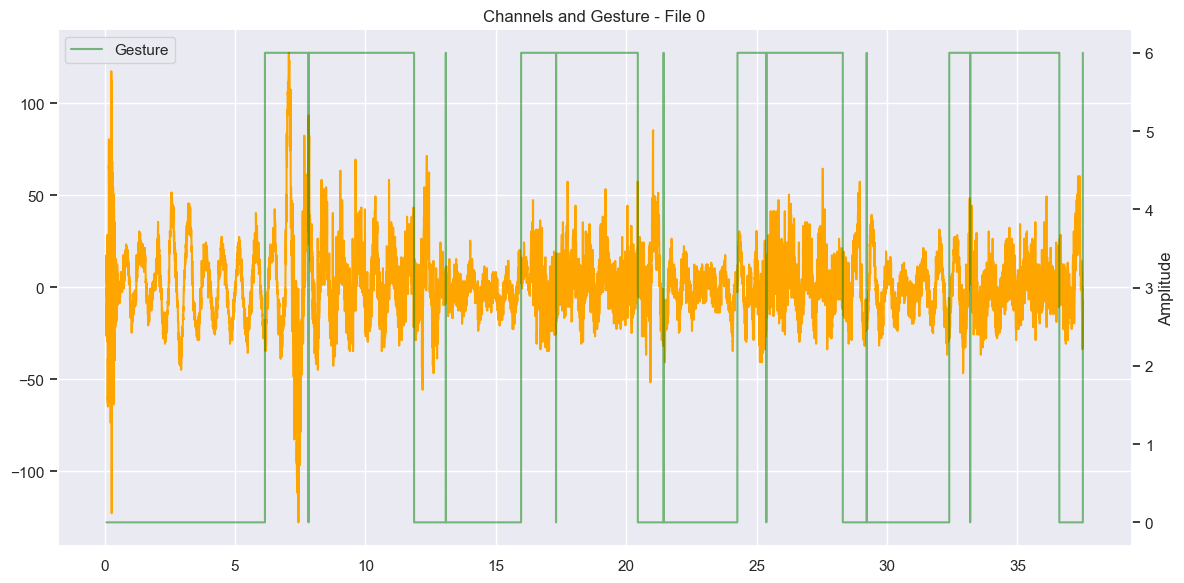

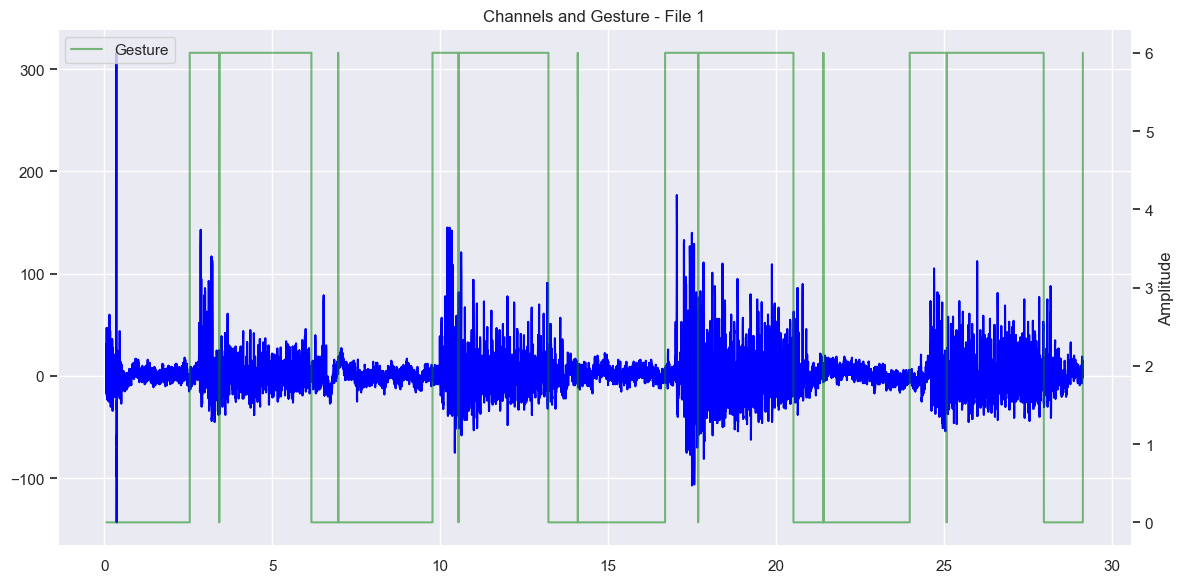

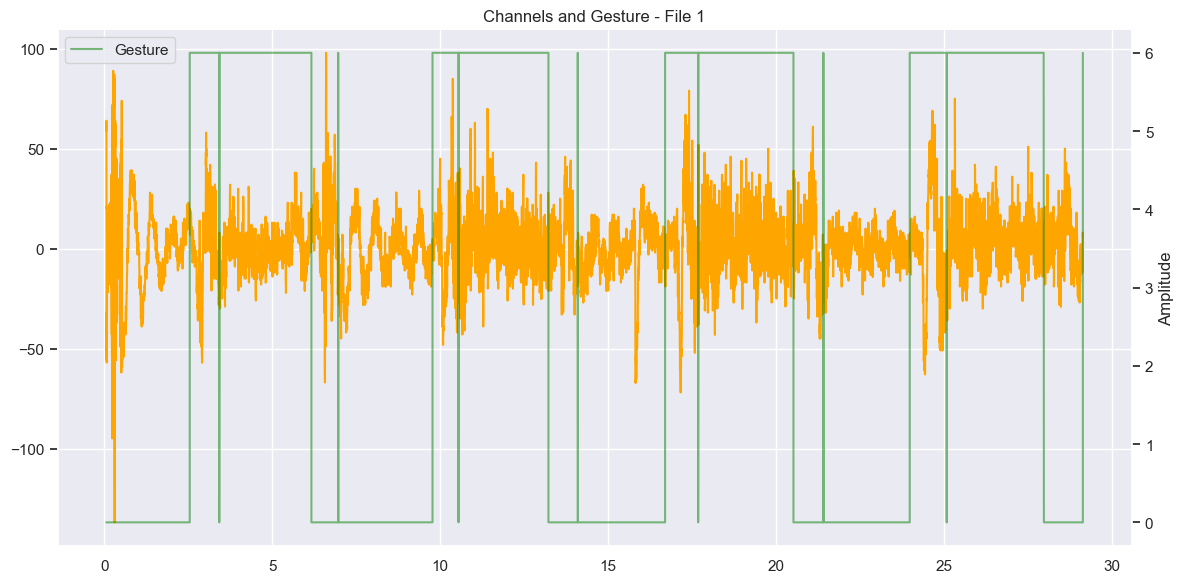

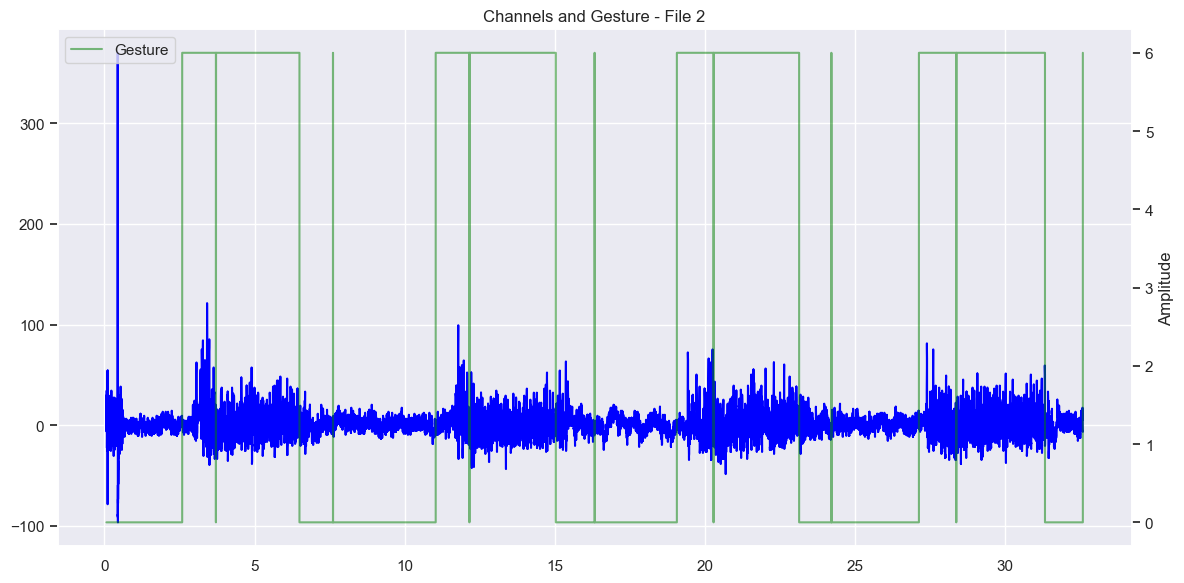

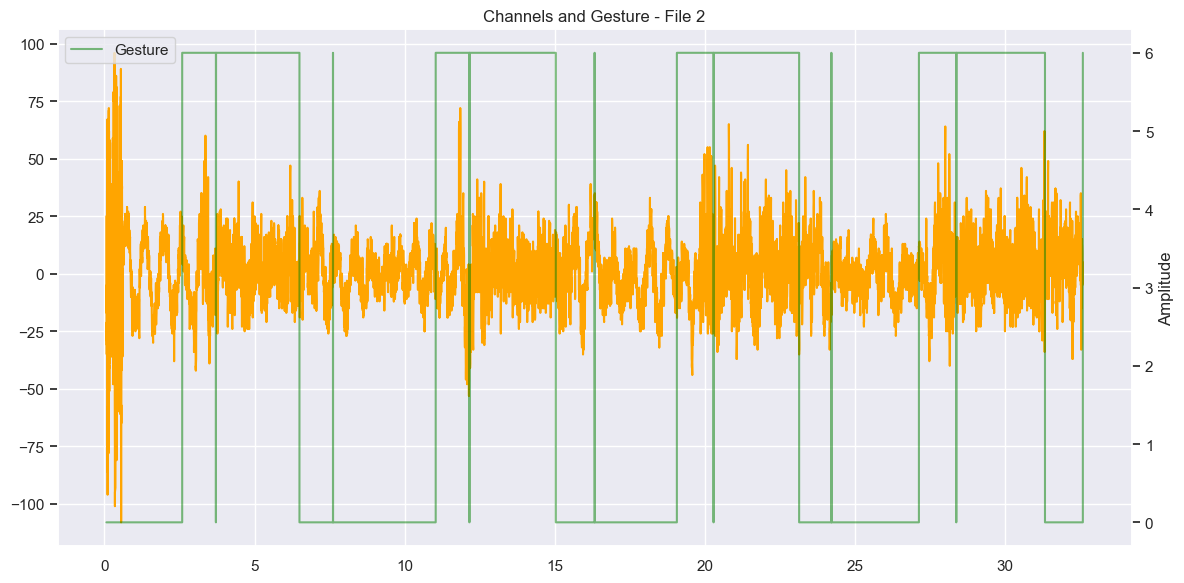

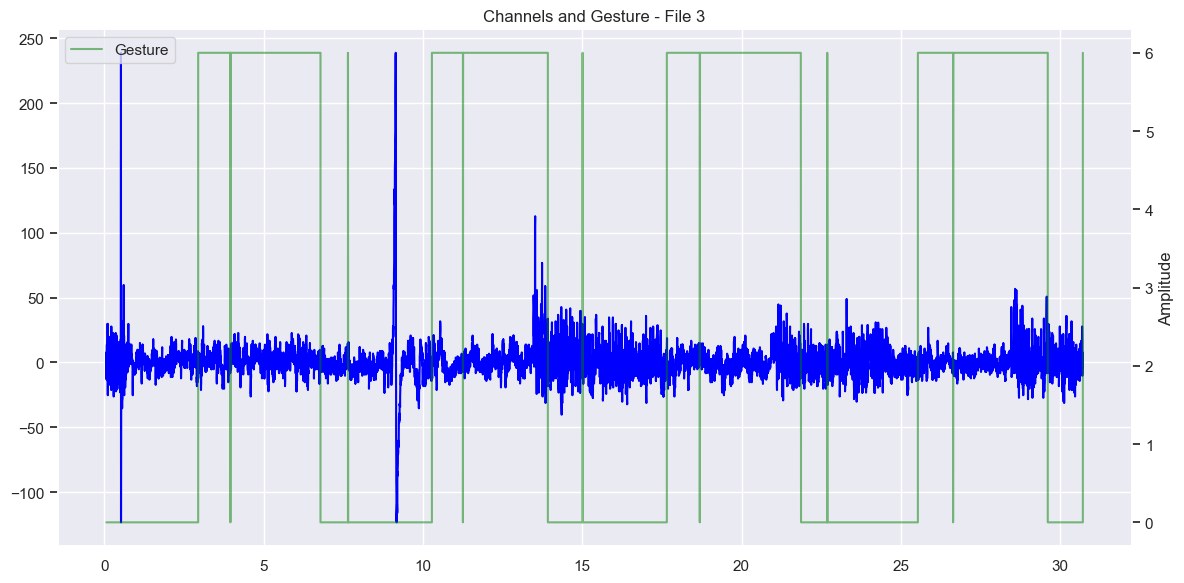

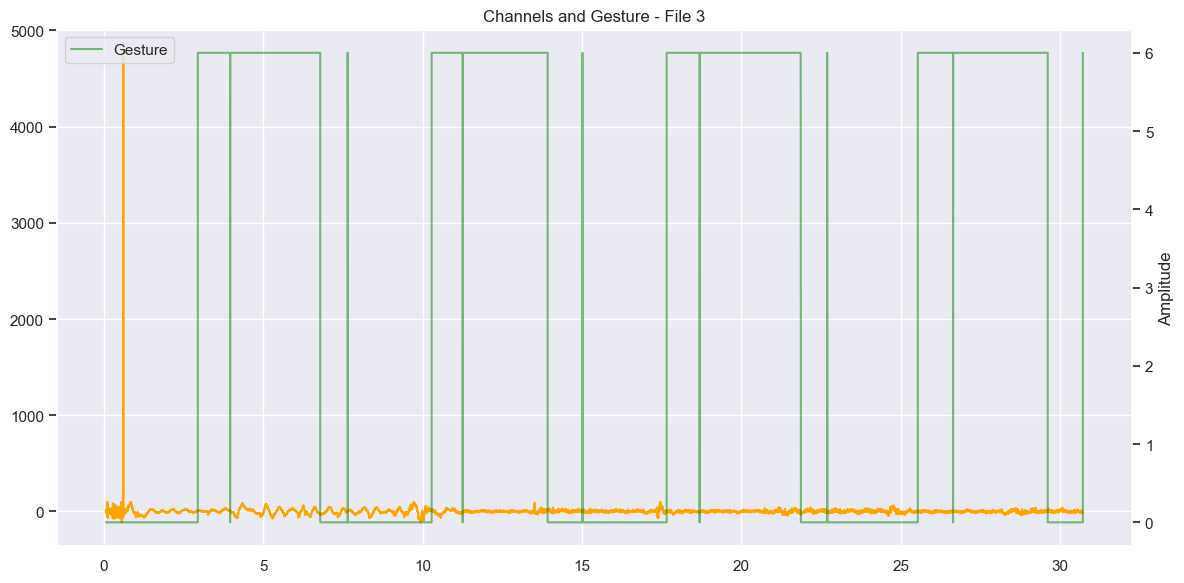

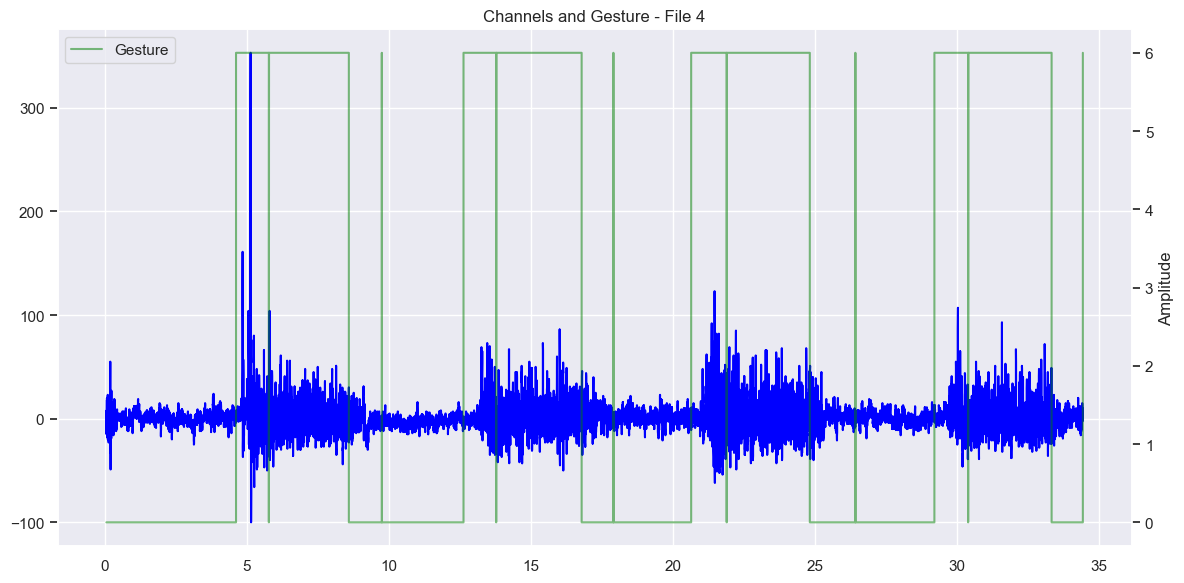

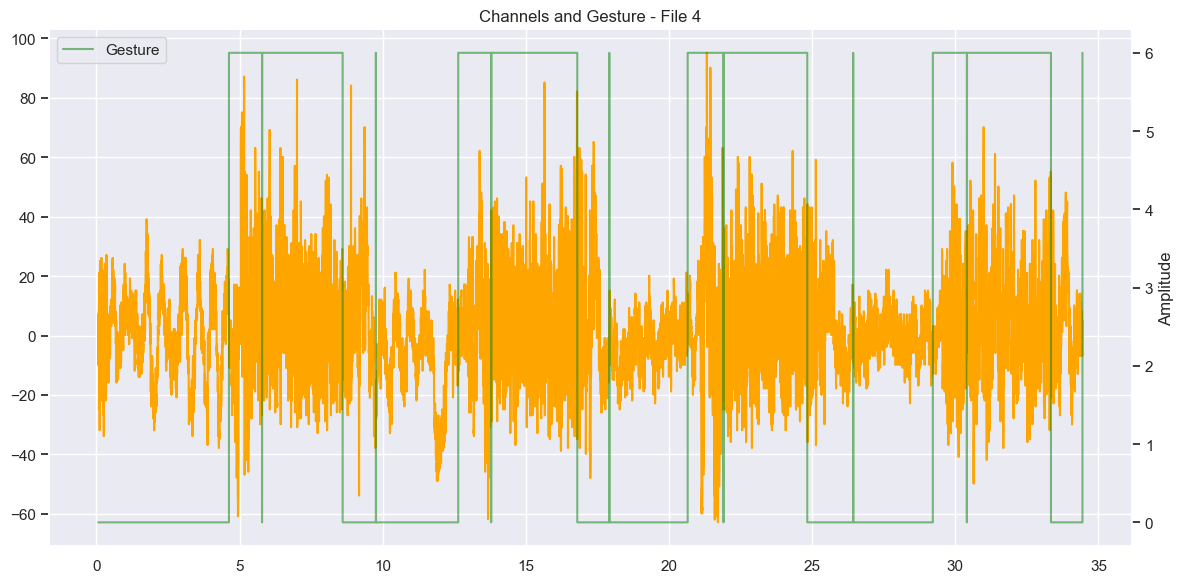

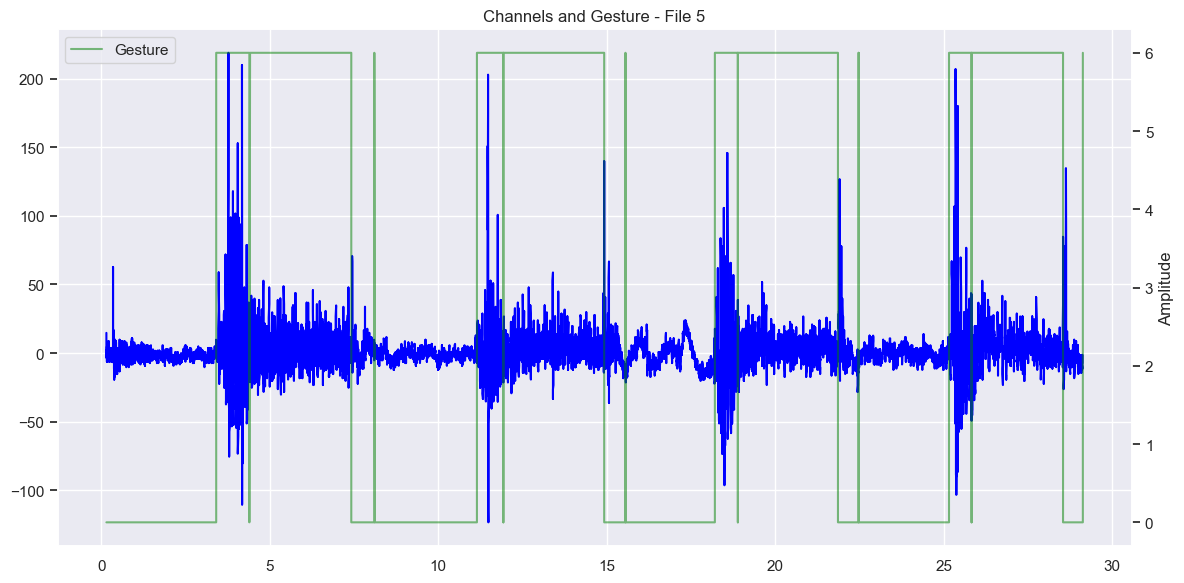

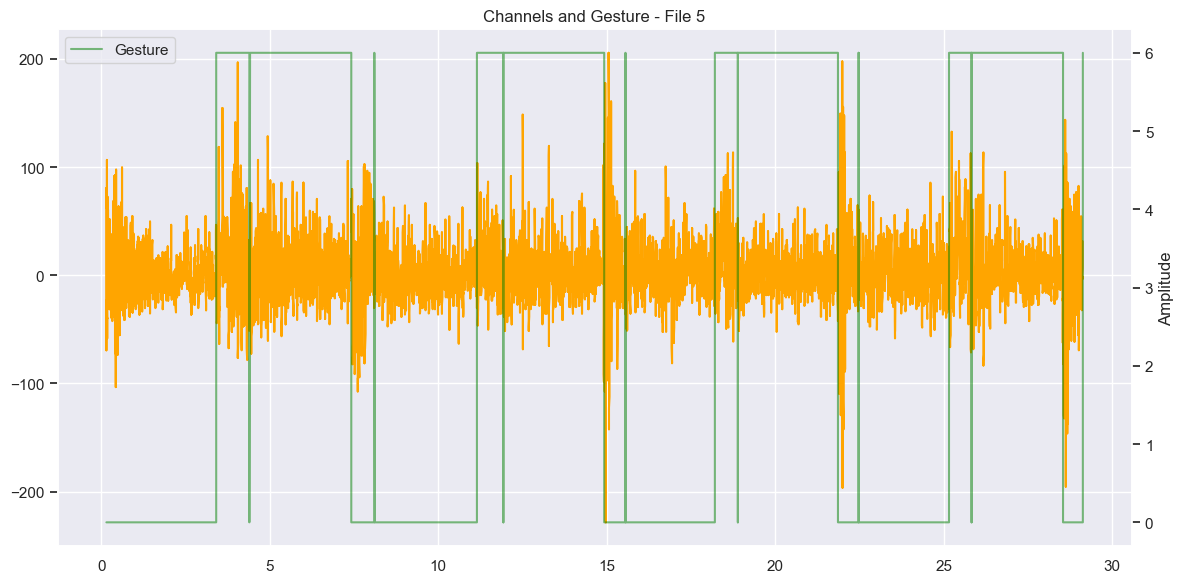

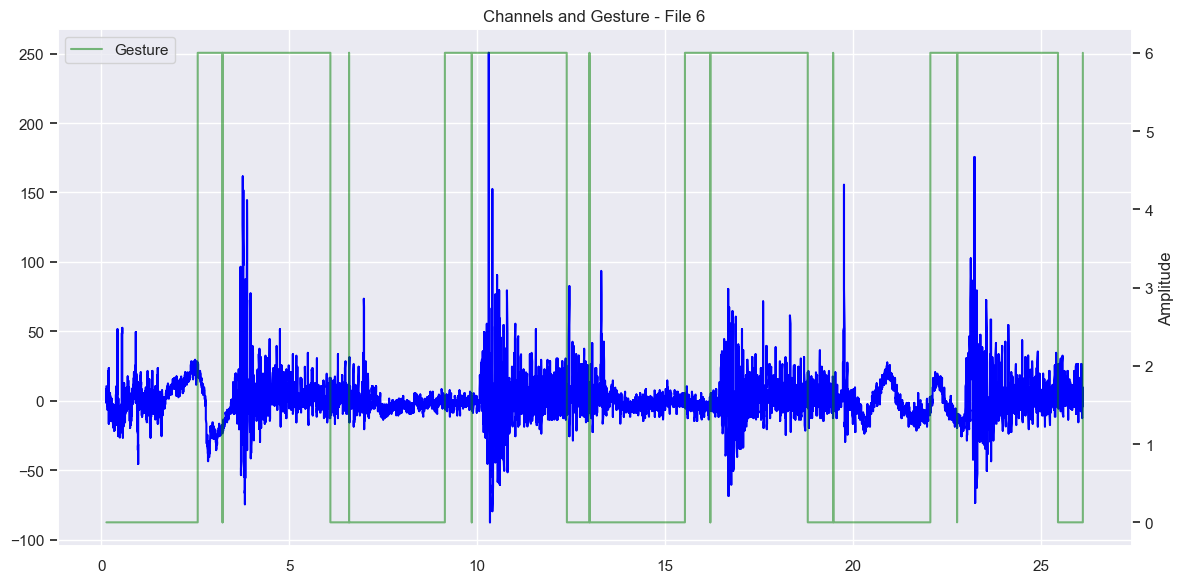

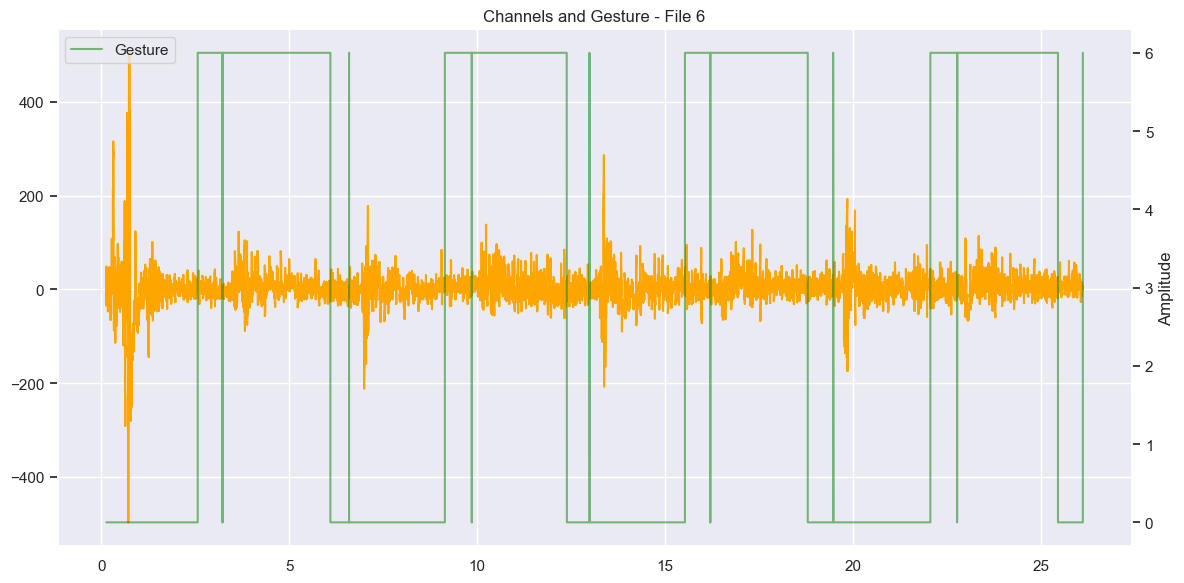

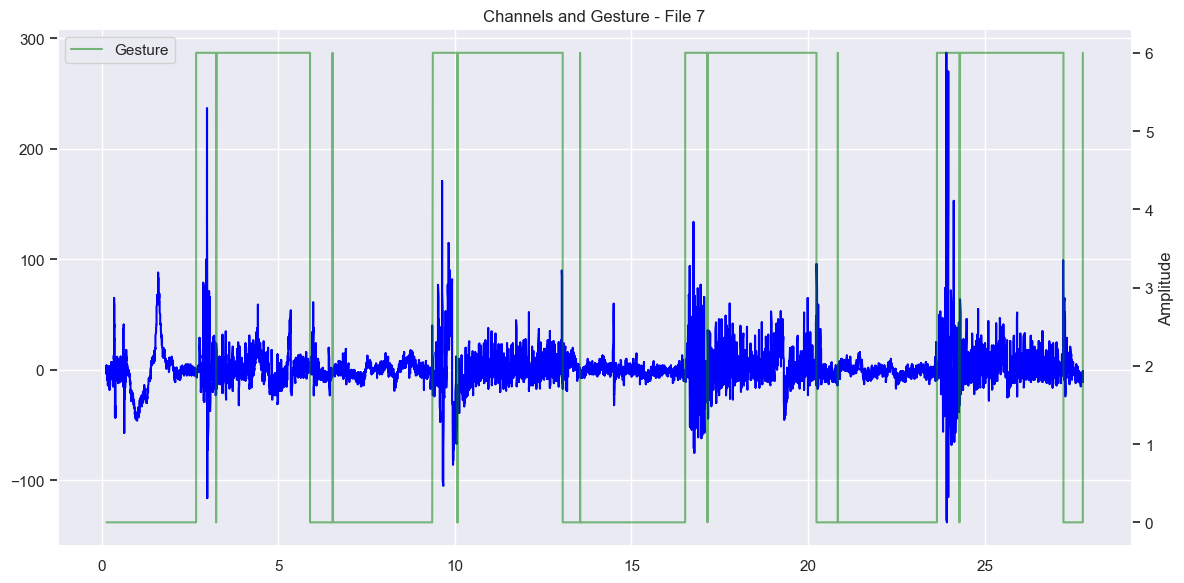

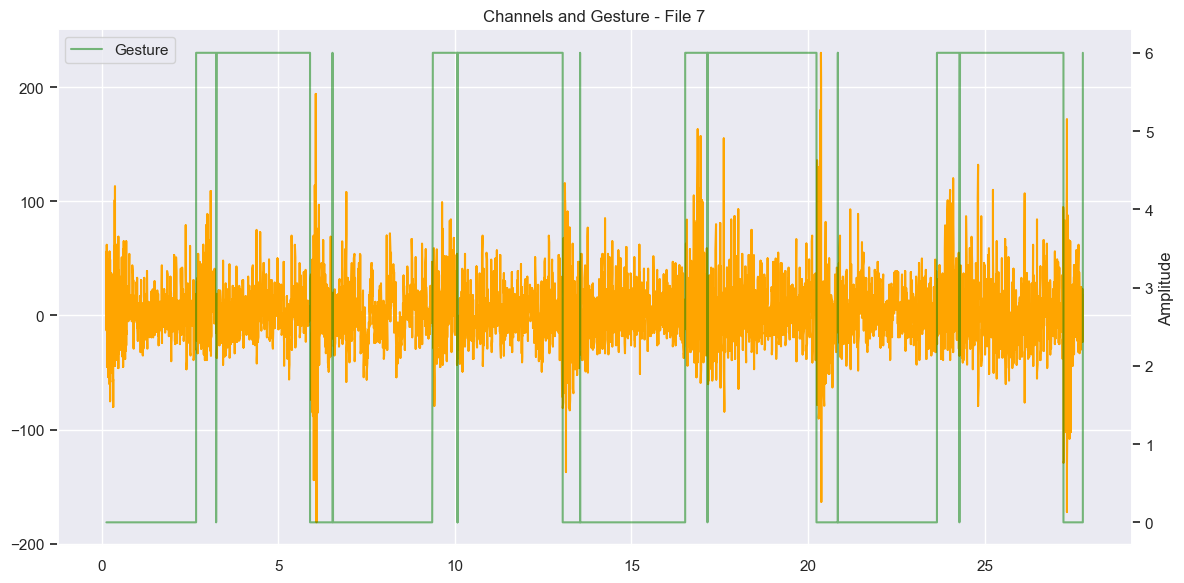

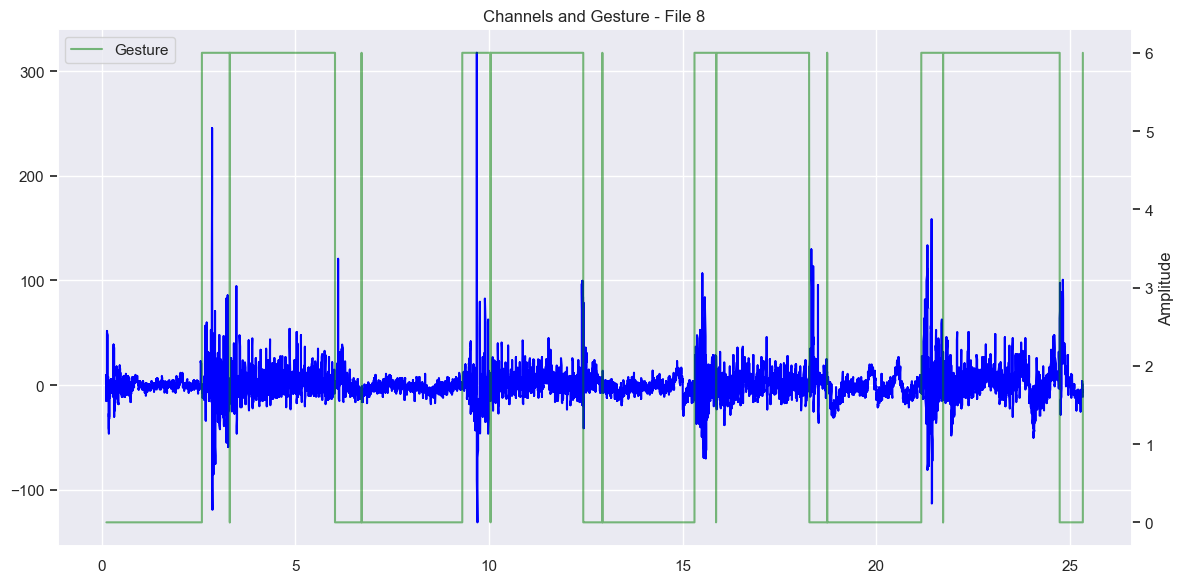

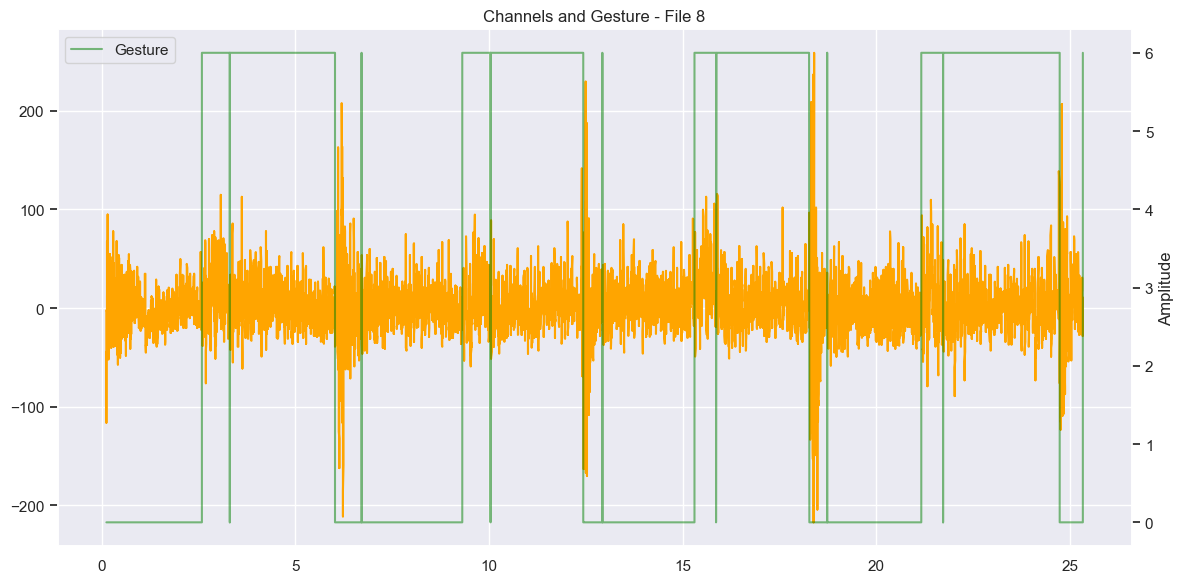

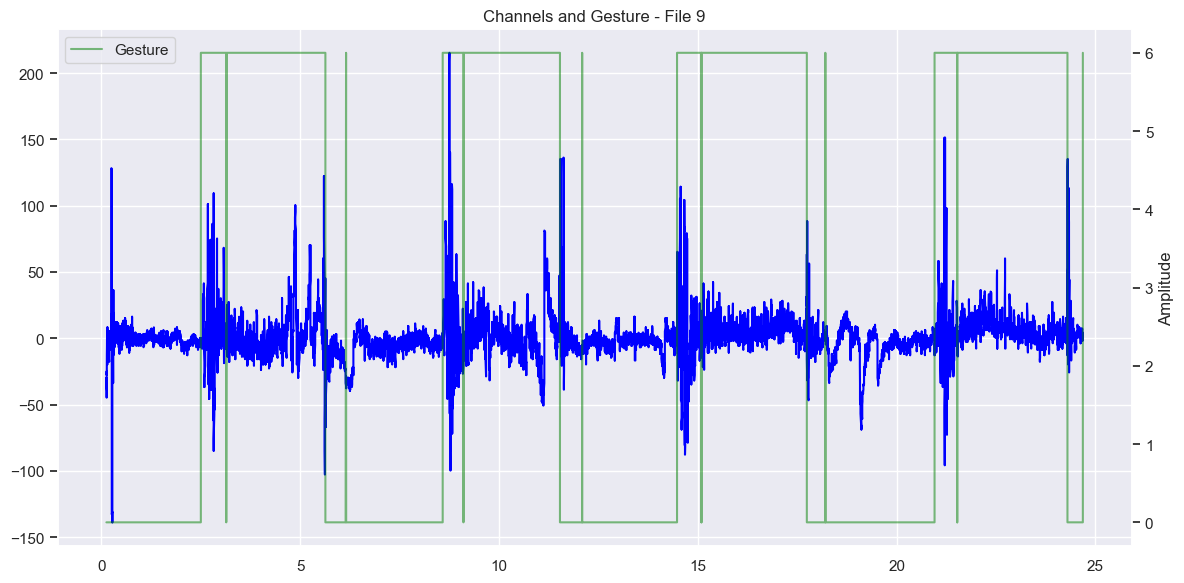

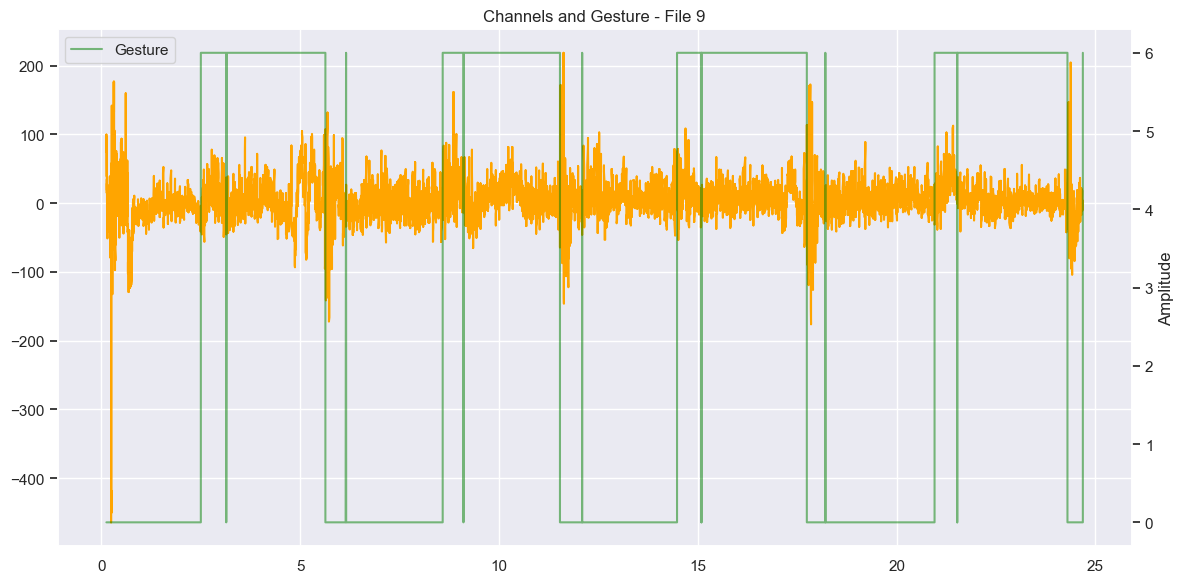

In [162]:
# Plot Channel1 and Channel2 with Gesture in the background
for i, data in enumerate(list_npulse_cleaned_data):
    plt.figure(figsize=(12, 6))  # Adjust the figure size

    # Plot Channel1 and Channel2
    plt.plot(data['Timestamp'], data['Channel1'], label='Channel 1', color='blue')

    # Add Gesture in the background with its own scale
    plt.twinx()  # Create a second y-axis
    plt.plot(data['Timestamp'], data['Gesture'], label='Gesture', color='green', alpha=0.5)
    plt.ylabel('Gesture')

    # Add titles and labels
    plt.title(f'Channels and Gesture - File {i}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left')
    plt.grid()

    # Show the figure
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))  # Adjust the figure size

    # Plot Channel1 and Channel2
    plt.plot(data['Timestamp'], data['Channel2'], label='Channel 2', color='orange')

    # Add Gesture in the background with its own scale
    plt.twinx()  # Create a second y-axis
    plt.plot(data['Timestamp'], data['Gesture'], label='Gesture', color='green', alpha=0.5)
    plt.ylabel('Gesture')

    # Add titles and labels
    plt.title(f'Channels and Gesture - File {i}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left')
    plt.grid()

    # Show the figure
    plt.tight_layout()
    plt.show()


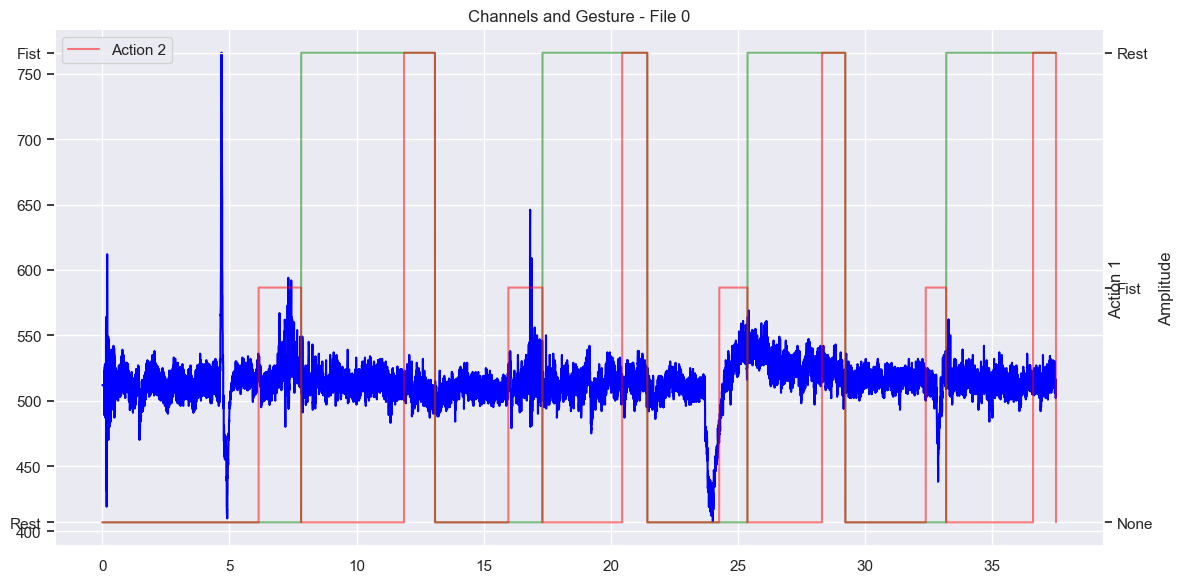

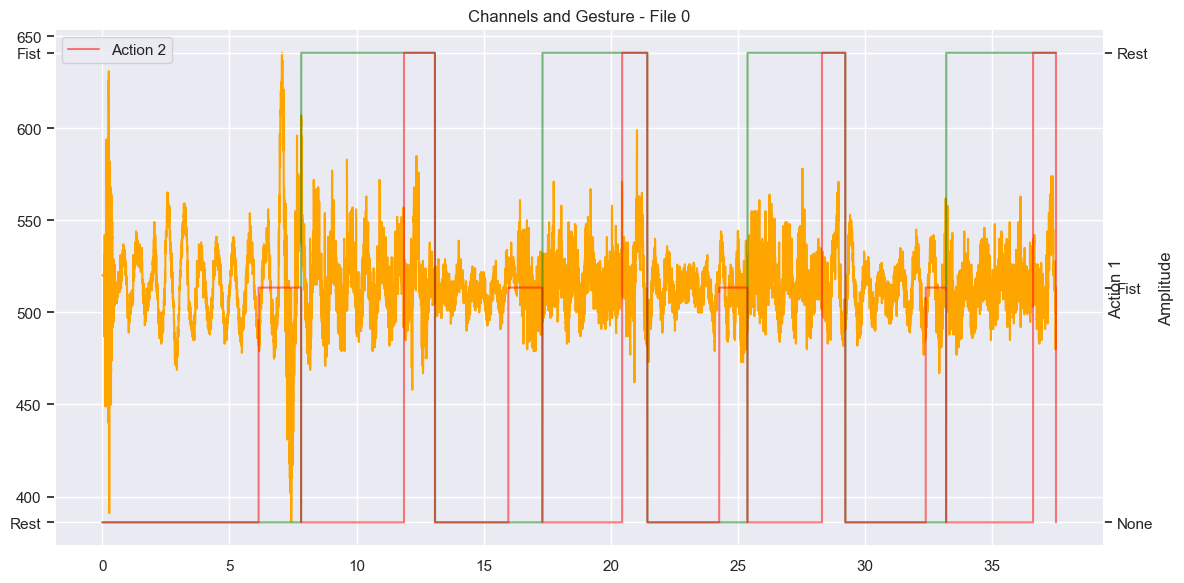

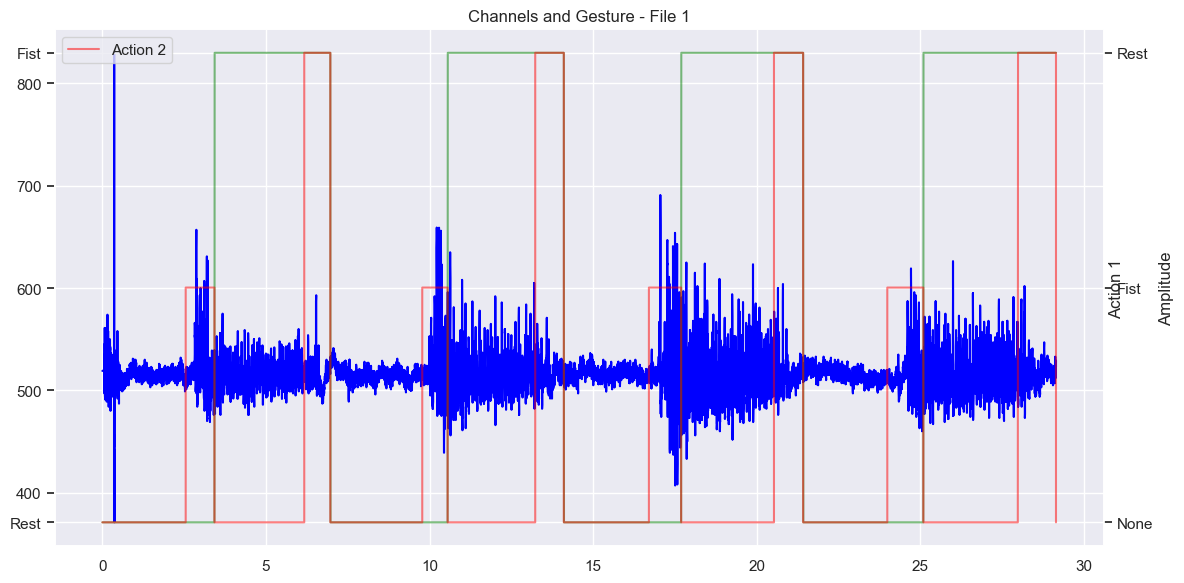

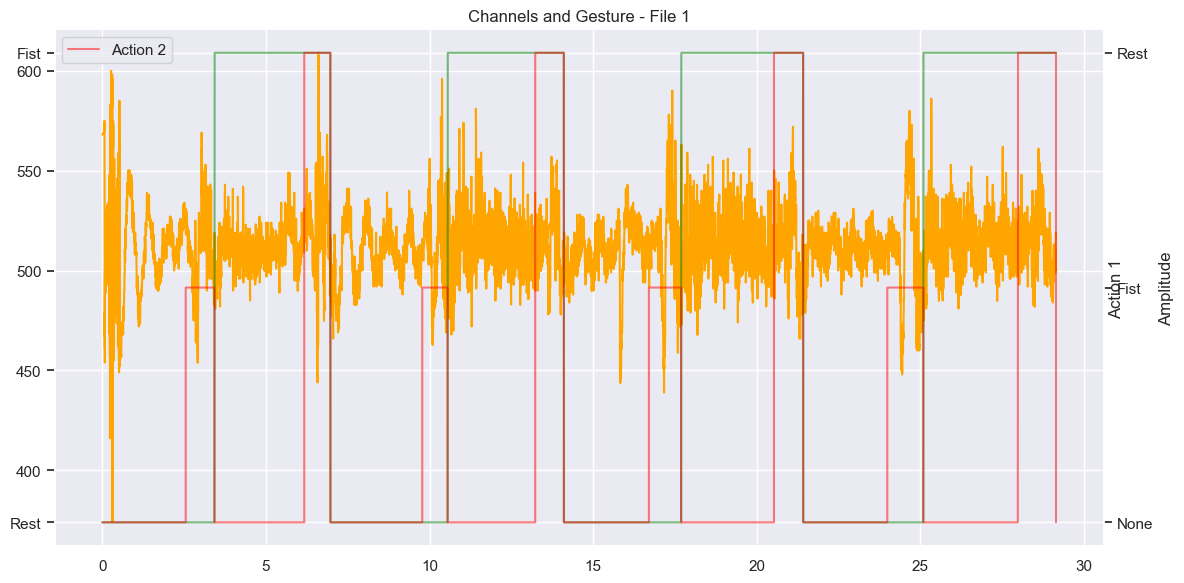

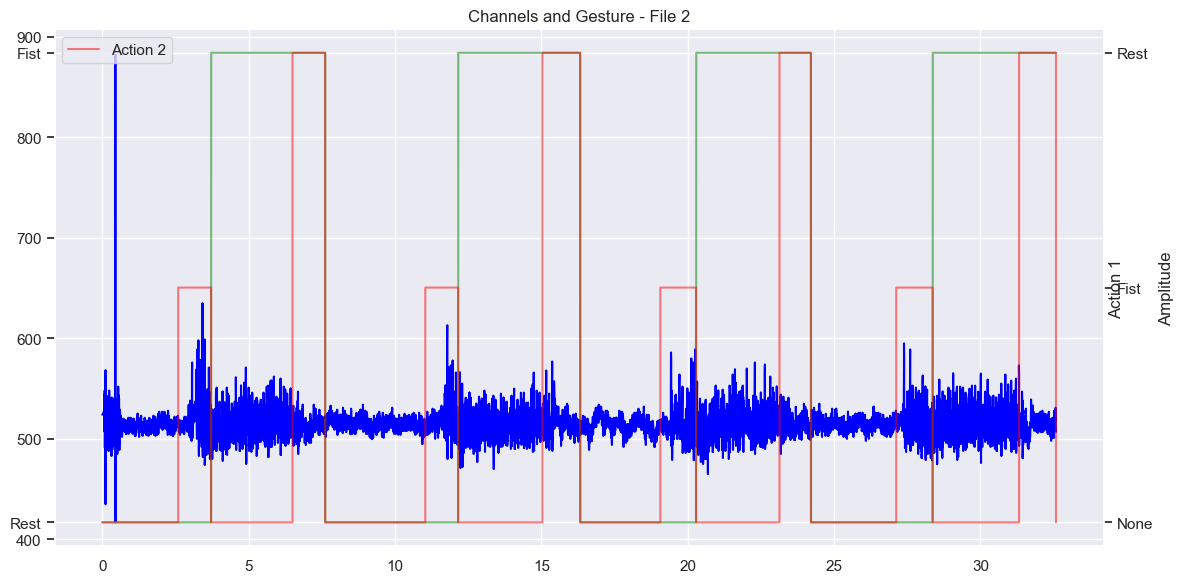

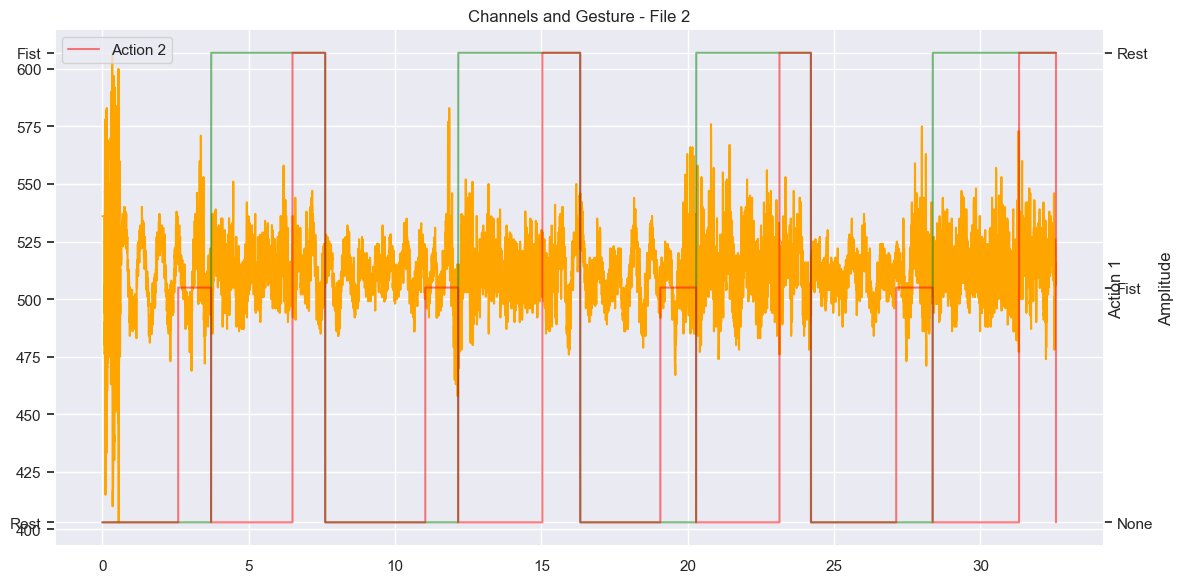

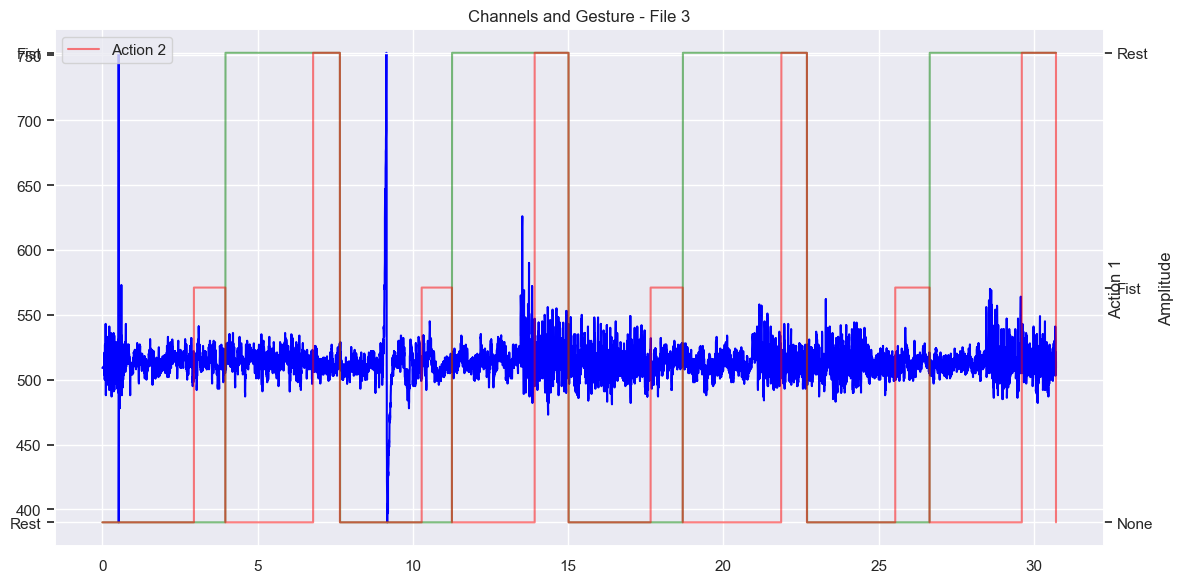

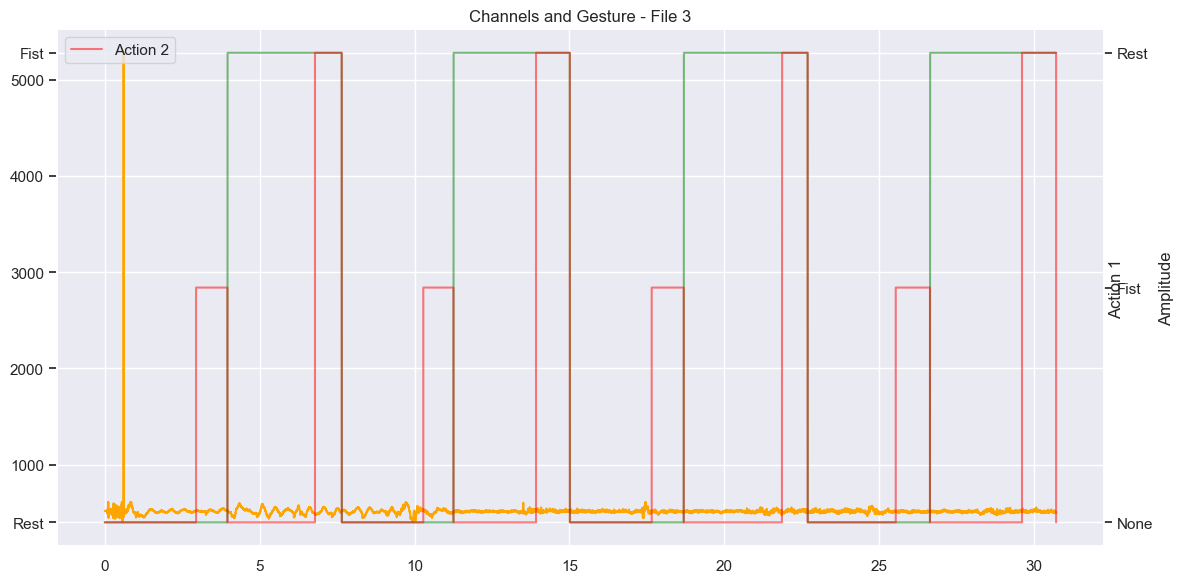

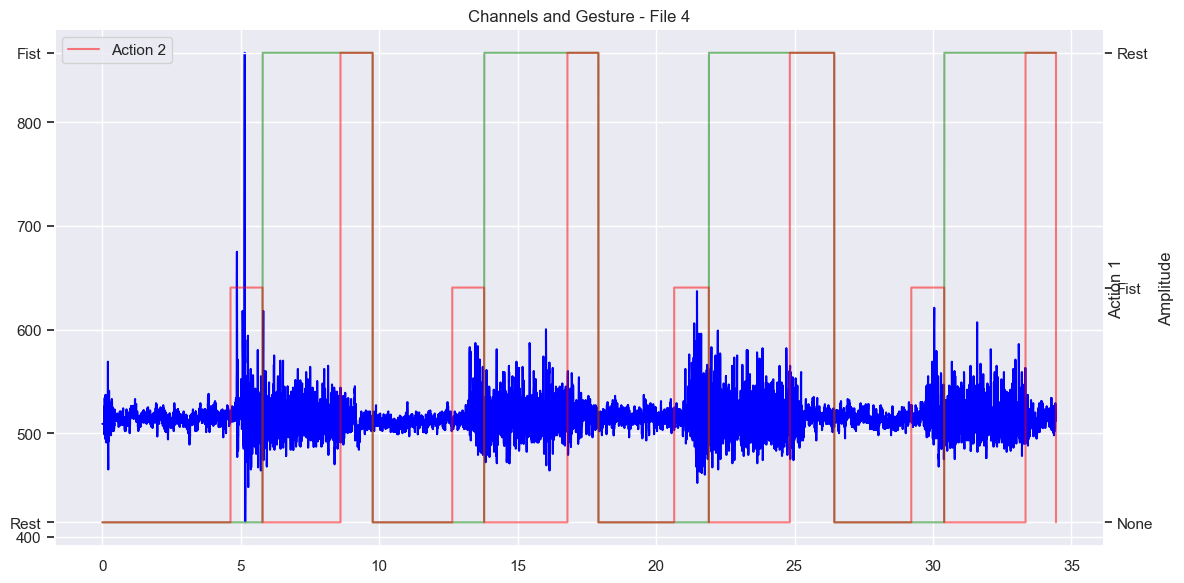

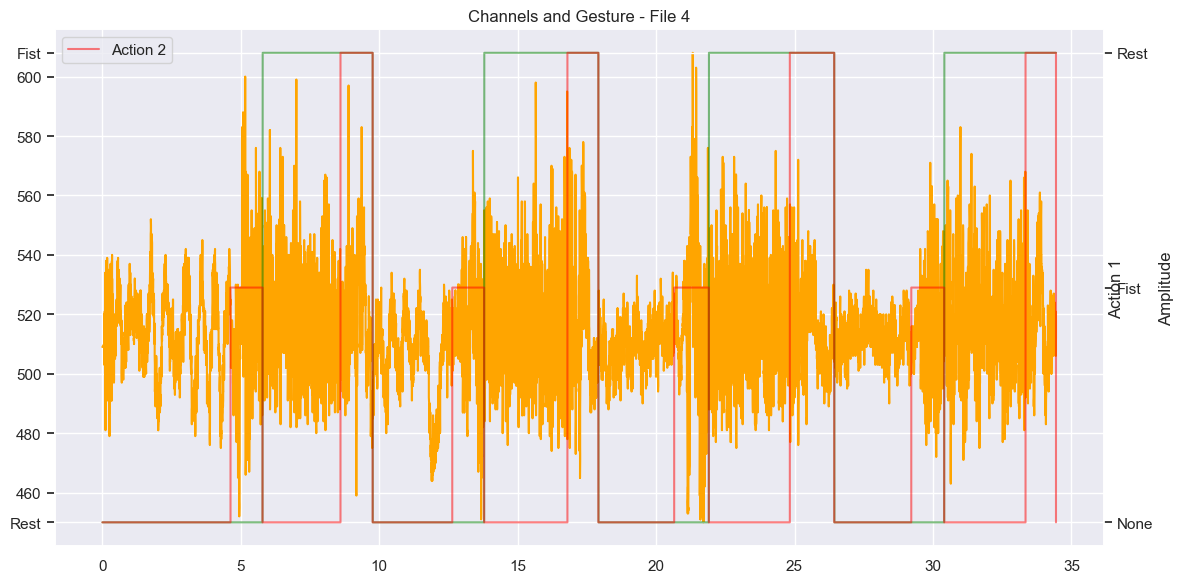

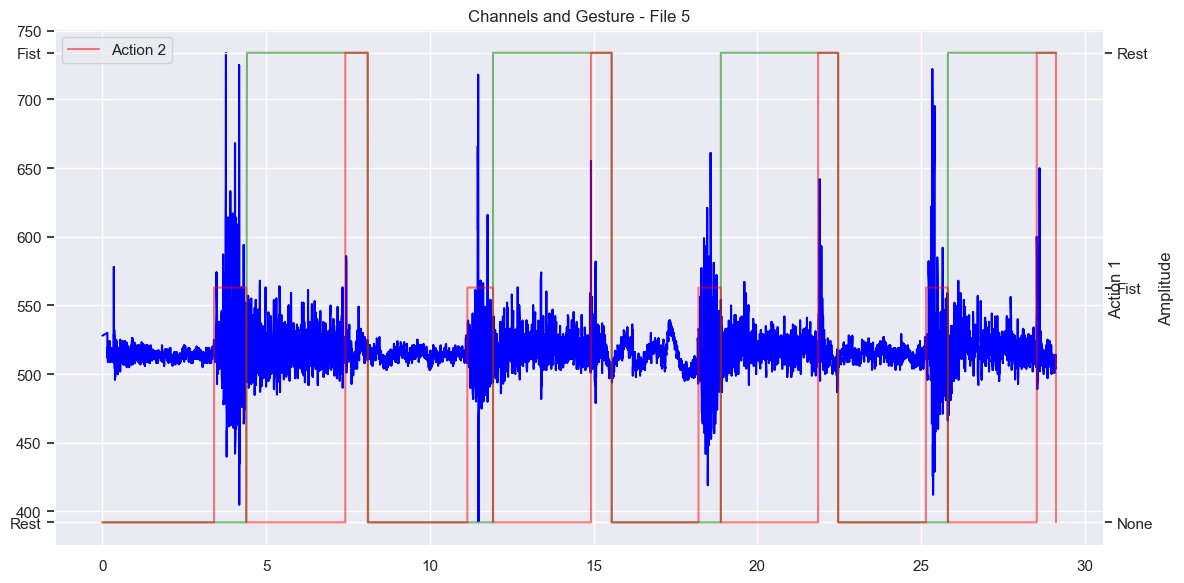

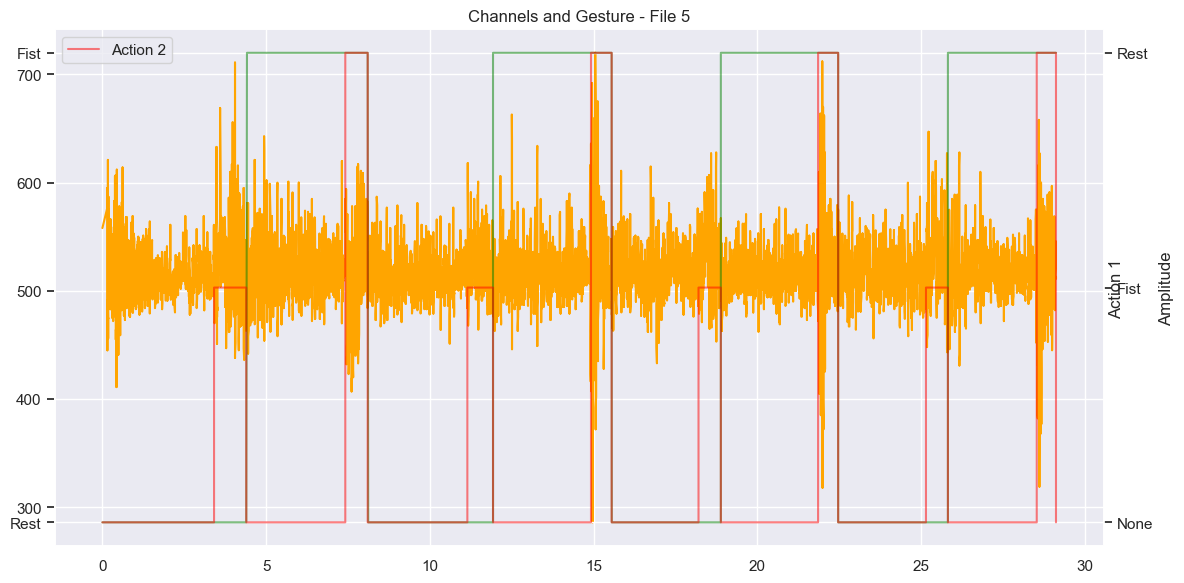

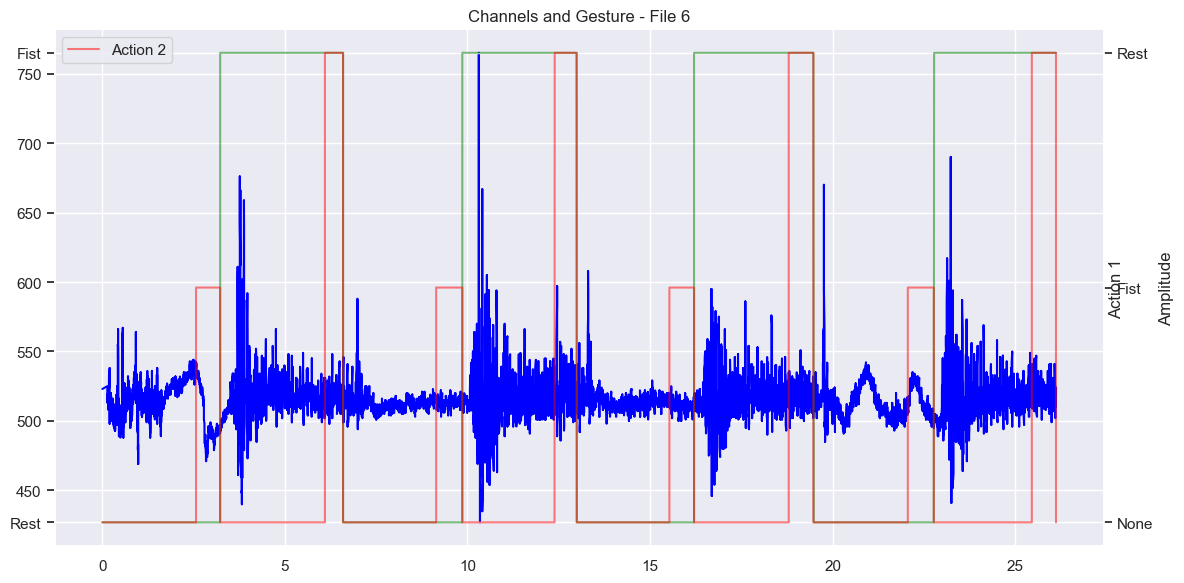

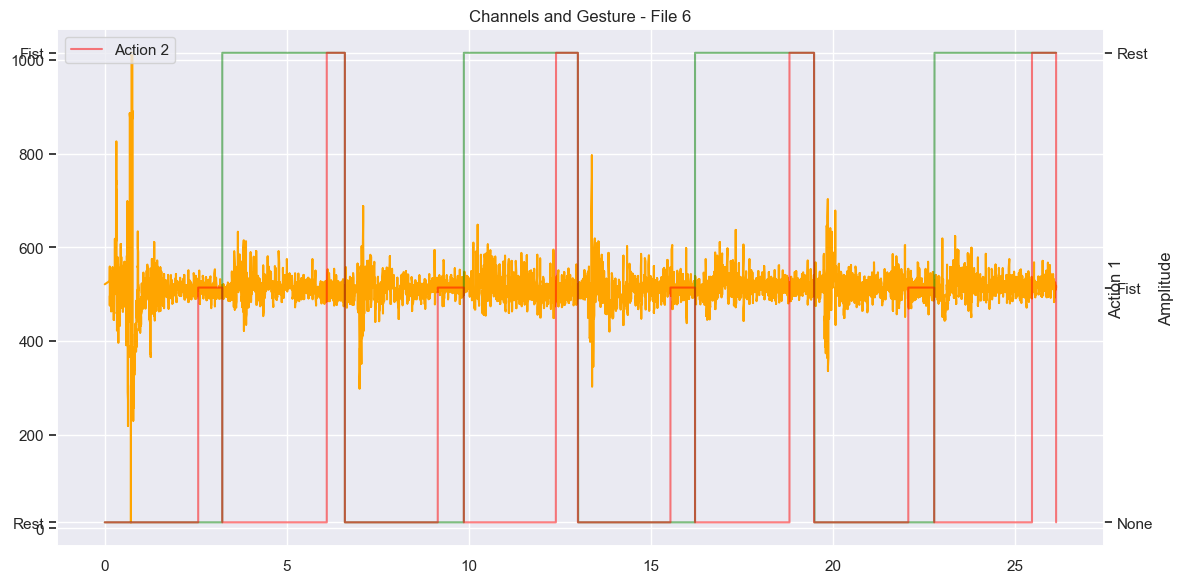

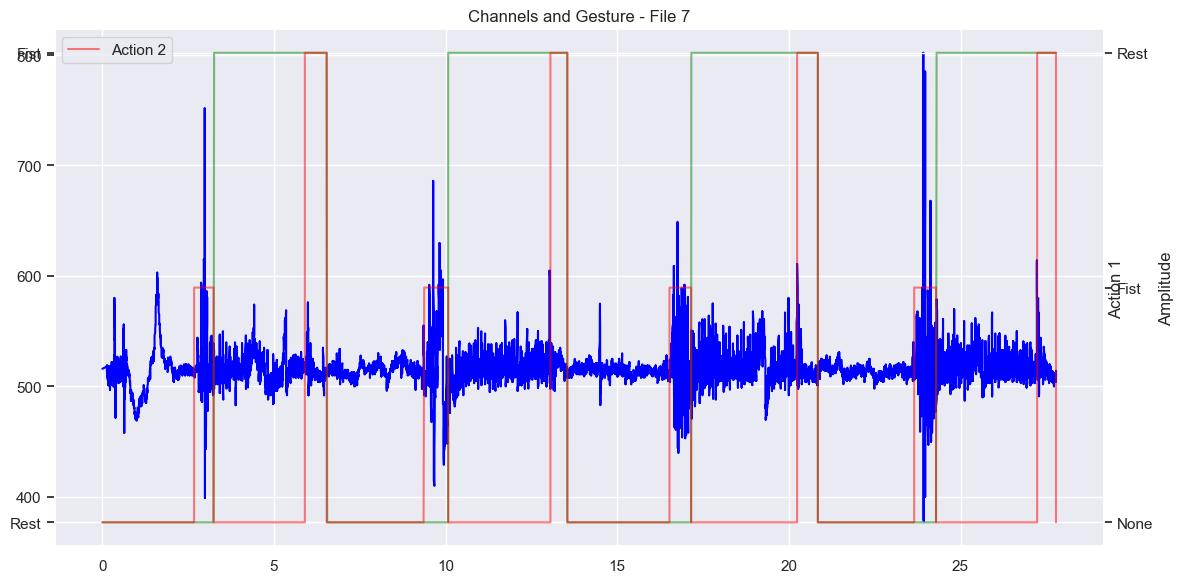

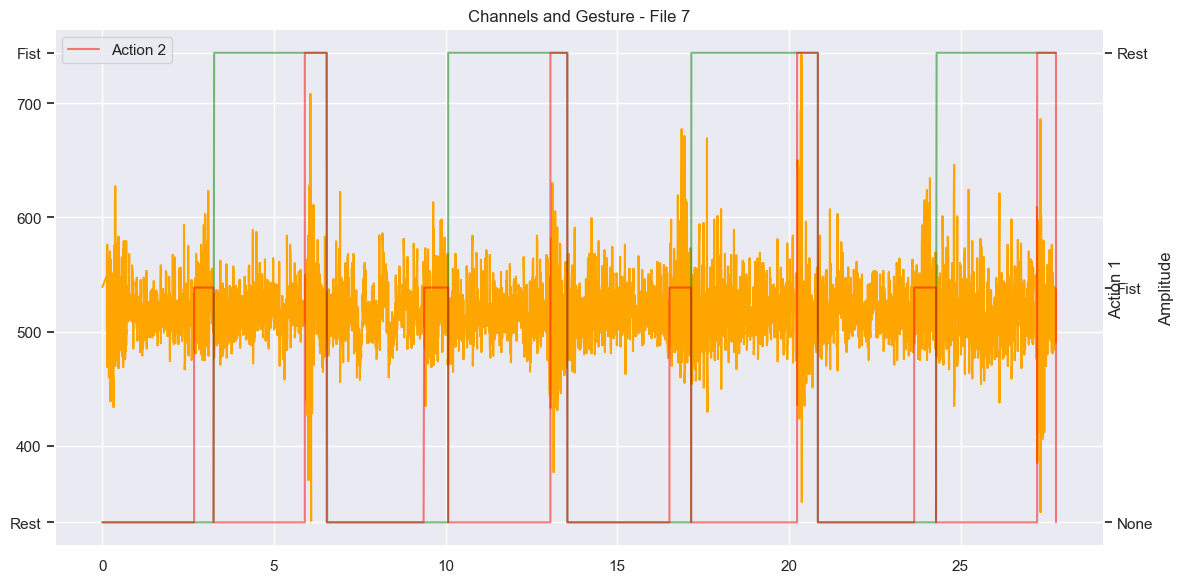

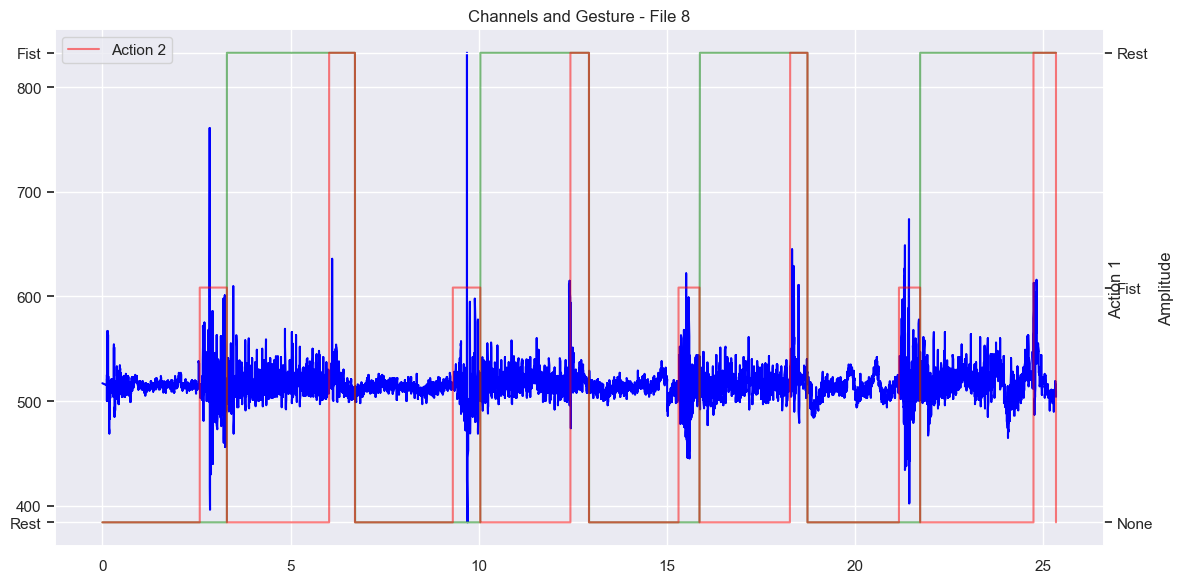

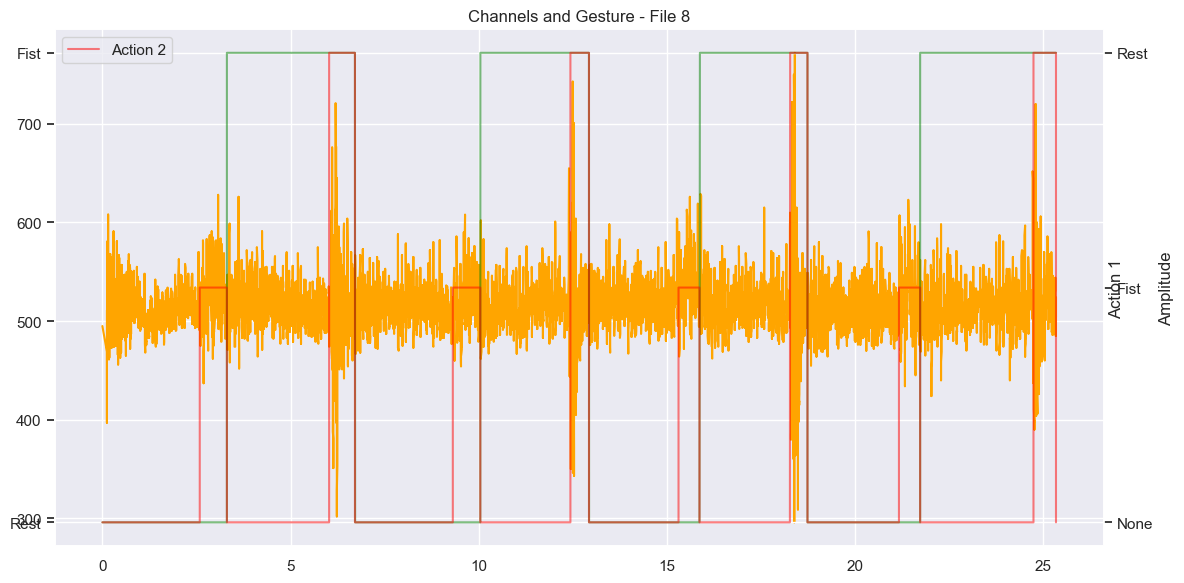

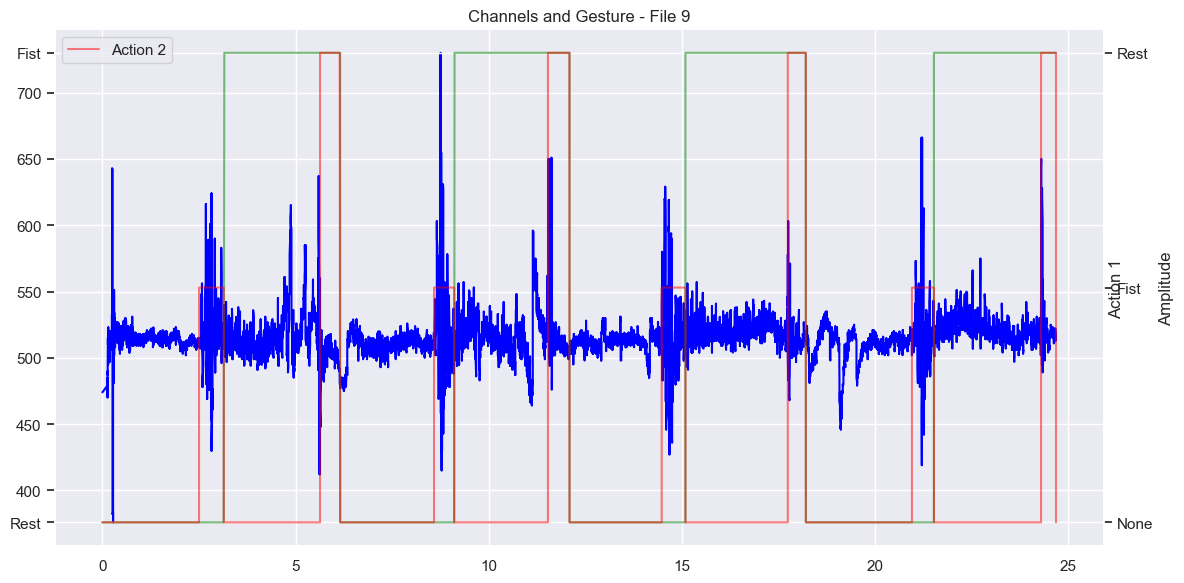

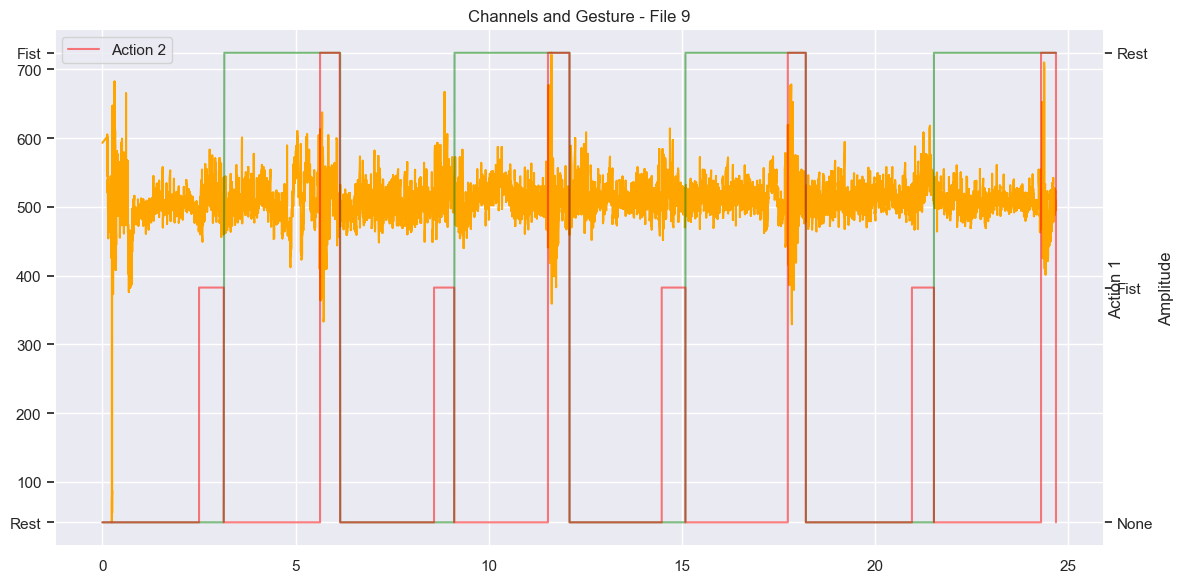

In [163]:
# Plot Channel1 and Channel2 with Gesture in the background
for i, data in enumerate(list_npulse_raw_data):
    plt.figure(figsize=(12, 6))  # Adjust the figure size

    # Plot Channel1 and Channel2
    plt.plot(data['Timestamp'], data['Channel1'], label='Channel 1', color='blue')

    # Add Gesture in the background with its own scale
    plt.twinx()  # Create a second y-axis
    plt.plot(data['Timestamp'], data['Action1'], label='Action 1', color='green', alpha=0.5)
    plt.ylabel('Action 1')

    plt.twinx()  # Create a second y-axis
    plt.plot(data['Timestamp'], data['Action2'], label='Action 2', color='red', alpha=0.5)
    plt.ylabel('Action 2')

    # Add titles and labels
    plt.title(f'Channels and Gesture - File {i}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left')
    plt.grid()

    # Show the figure
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))  # Adjust the figure size

    # Plot Channel1 and Channel2
    plt.plot(data['Timestamp'], data['Channel2'], label='Channel 2', color='orange')

    # Add Gesture in the background with its own scale
    plt.twinx()  # Create a second y-axis
    plt.plot(data['Timestamp'], data['Action1'], label='Action 1', color='green', alpha=0.5)
    plt.ylabel('Action 1')

    plt.twinx()  # Create a second y-axis
    plt.plot(data['Timestamp'], data['Action2'], label='Action 2', color='red', alpha=0.5)
    plt.ylabel('Action 2')

    # Add titles and labels
    plt.title(f'Channels and Gesture - File {i}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left')
    plt.grid()

    # Show the figure
    plt.tight_layout()
    plt.show()


In [164]:
# good_trials = [0, 5, 7, 9, 10, 11, 12, 13] # Good trials to keep
# bad_trials = [1, 2, 3, 4, 6, 8]

# # Select good trials
# list_npulse_good_cleaned_data = [list_npulse_cleaned_data[i] for i in good_trials]

list_npulse_good_cleaned_data = list_npulse_cleaned_data.copy()

# a) Single classification

## Training, testing data

In [165]:
# Divide the data into training and testing sets
dataset_size = len(list_npulse_good_cleaned_data)


test_size = int(dataset_size * 0.2)  # 20% for testing
train_size = dataset_size - test_size  # 80% for training

# Take random Files from the list
# train_files = random.sample(list_npulse_cleaned_data, k=train_size)  # Randomly sample without replacement
# test_files = [file for file in list_npulse_cleaned_data if file not in train_files]
train_files_id = random.sample(range(dataset_size), k=train_size)
test_files_id = [file for file in range(dataset_size) if file not in train_files_id]

print(f"Train files: {train_files_id}")
print(f"Test files: {test_files_id}")

# Concatenate the dataframes
train_data = pd.concat([list_npulse_good_cleaned_data[i] for i in train_files_id], ignore_index=True)
test_data = pd.concat([list_npulse_good_cleaned_data[i] for i in test_files_id], ignore_index=True)

print(f"Train data shape: {train_data.head()}")
print(f"Test data shape: {test_data.head()}")

Train files: [3, 7, 6, 5, 4, 2, 9, 0]
Test files: [1, 8]
Train data shape:    Timestamp  Channel1  Channel2  Gesture
0      0.069 -2.251673  4.688353        0
1      0.071  1.748327  5.688353        0
2      0.071  0.748327  4.688353        0
3      0.071  1.748327  7.688353        0
4      0.071  2.748327  7.688353        0
Test data shape:    Timestamp   Channel1   Channel2  Gesture
0      0.065   5.842699  59.059575        0
1      0.065   1.842699  60.059575        0
2      0.065  -6.157301  60.059575        0
3      0.065 -17.157301  57.059575        0
4      0.066 -16.157301  55.059575        0


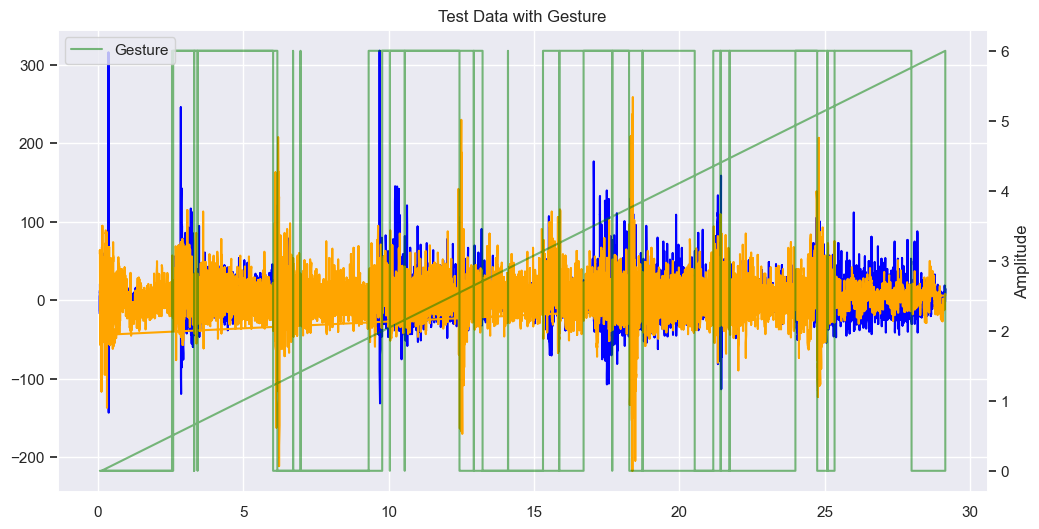

In [166]:
# Plot test data with gesture
plt.figure(figsize=(12, 6))  # Adjust the figure size
plt.plot(test_data['Timestamp'], test_data['Channel1'], label='Channel 1', color='blue')
plt.plot(test_data['Timestamp'], test_data['Channel2'], label='Channel 2', color='orange')
plt.twinx()
plt.plot(test_data['Timestamp'], test_data['Gesture'], label='Gesture', color='green', alpha=0.5)
plt.title('Test Data with Gesture')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [167]:
zero_crossing(test_data['Channel1'].values[1000:1500])

81

## Features

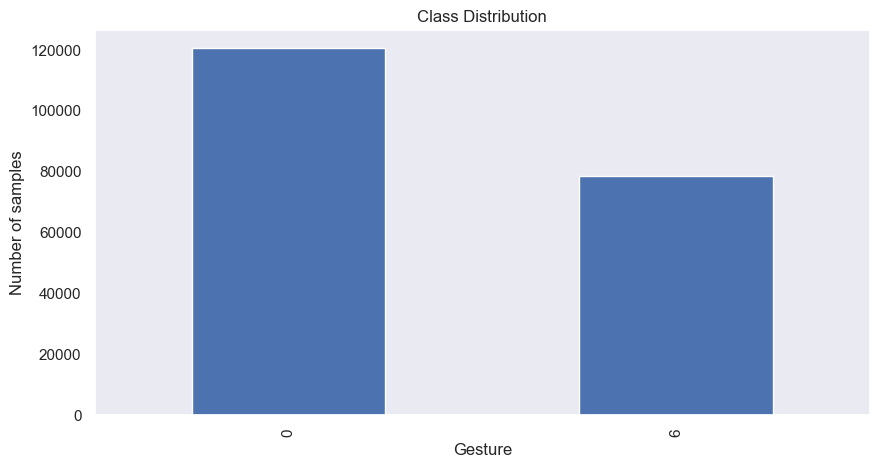

In [168]:
# balanced_train_data = balance_rest(train_data, label_col='Gesture', rest_label=0, target_rest_ratio=0.5)
balanced_train_data = train_data.copy()

# Count each label
label_counts = balanced_train_data['Gesture'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Gesture")
plt.ylabel("Number of samples")
plt.grid()
plt.show()

In [169]:
time_window = 200 # 200 ms
time_sliding = 100 # 100 ms

fs = 1000 # Sampling frequency in Hz

window = int(time_window * fs / 1000) # Convert to samples
step = int(time_sliding * fs / 1000) # Convert to samples

# All features
# features_selected = [total_power, mav, rms, mean_freq, median_freq, peak_freq, maxav, std, wl, ssc, wamp]
# features_selected = [wl, rms, ssc, median_freq, total_power]

# Suggested features
# features_selected = [zc, ssc, wl, log_det, wamp, var, mav, rms]
features_selected = [wl, wamp, var, rms]

training_features, training_labels = extract_features_and_labels(balanced_train_data, features_selected, window=window, step_size=step)
testing_features, testing_labels = extract_features_and_labels(test_data, features_selected, window=window, step_size=step)

In [170]:
print(training_features.shape, training_labels.shape, testing_features.shape, testing_labels.shape)

(1987, 8) (1987,) (437, 8) (437,)


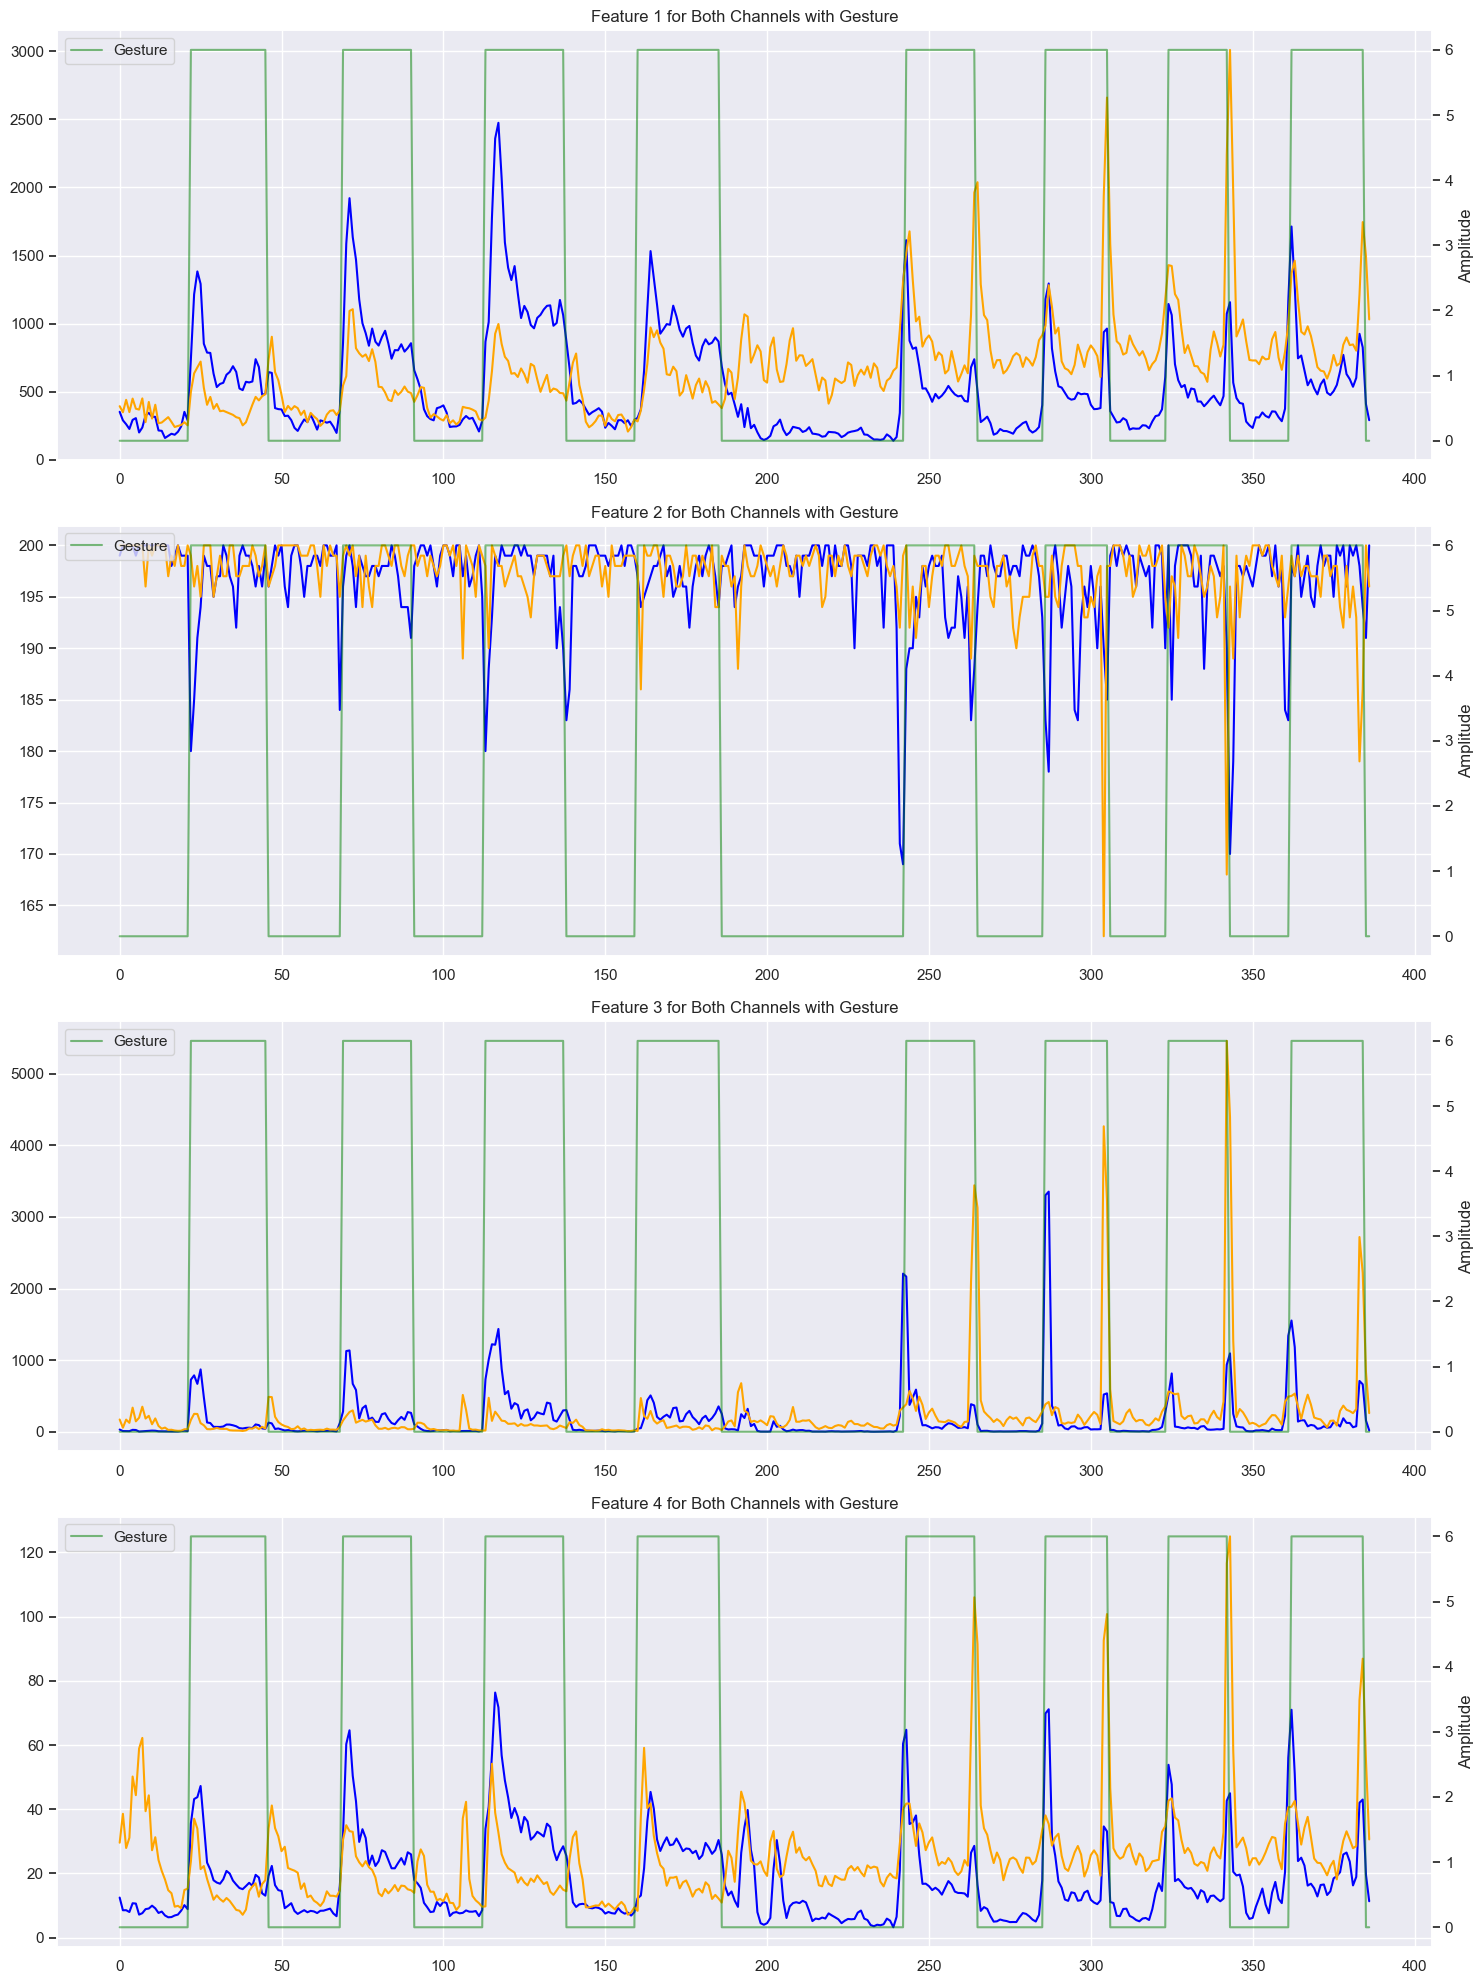

In [171]:
# Plot all features for testing data with 'Gesture' in the background
num_features = testing_features.shape[1] // 2  # Assuming equal features for both channels
plt.figure(figsize=(15, 5 * num_features))

for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(testing_features[50:, i], label=f'Feature {i + 1} (Channel 1)', color='blue')
    plt.plot(testing_features[50:, i + num_features], label=f'Feature {i + 1} (Channel 2)', color='orange')

    # Add Gesture in the background with its own scale
    plt.twinx()  # Create a second y-axis
    plt.plot(testing_labels[50:], label='Gesture', color='green', alpha=0.5)
    plt.ylabel('Gesture')

    # Add titles and labels
    plt.title(f'Feature {i + 1} for Both Channels with Gesture')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left')
    plt.grid()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [172]:
# Feature normalization
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
testing_features = scaler.transform(testing_features)  # Use the same scaler for testing data

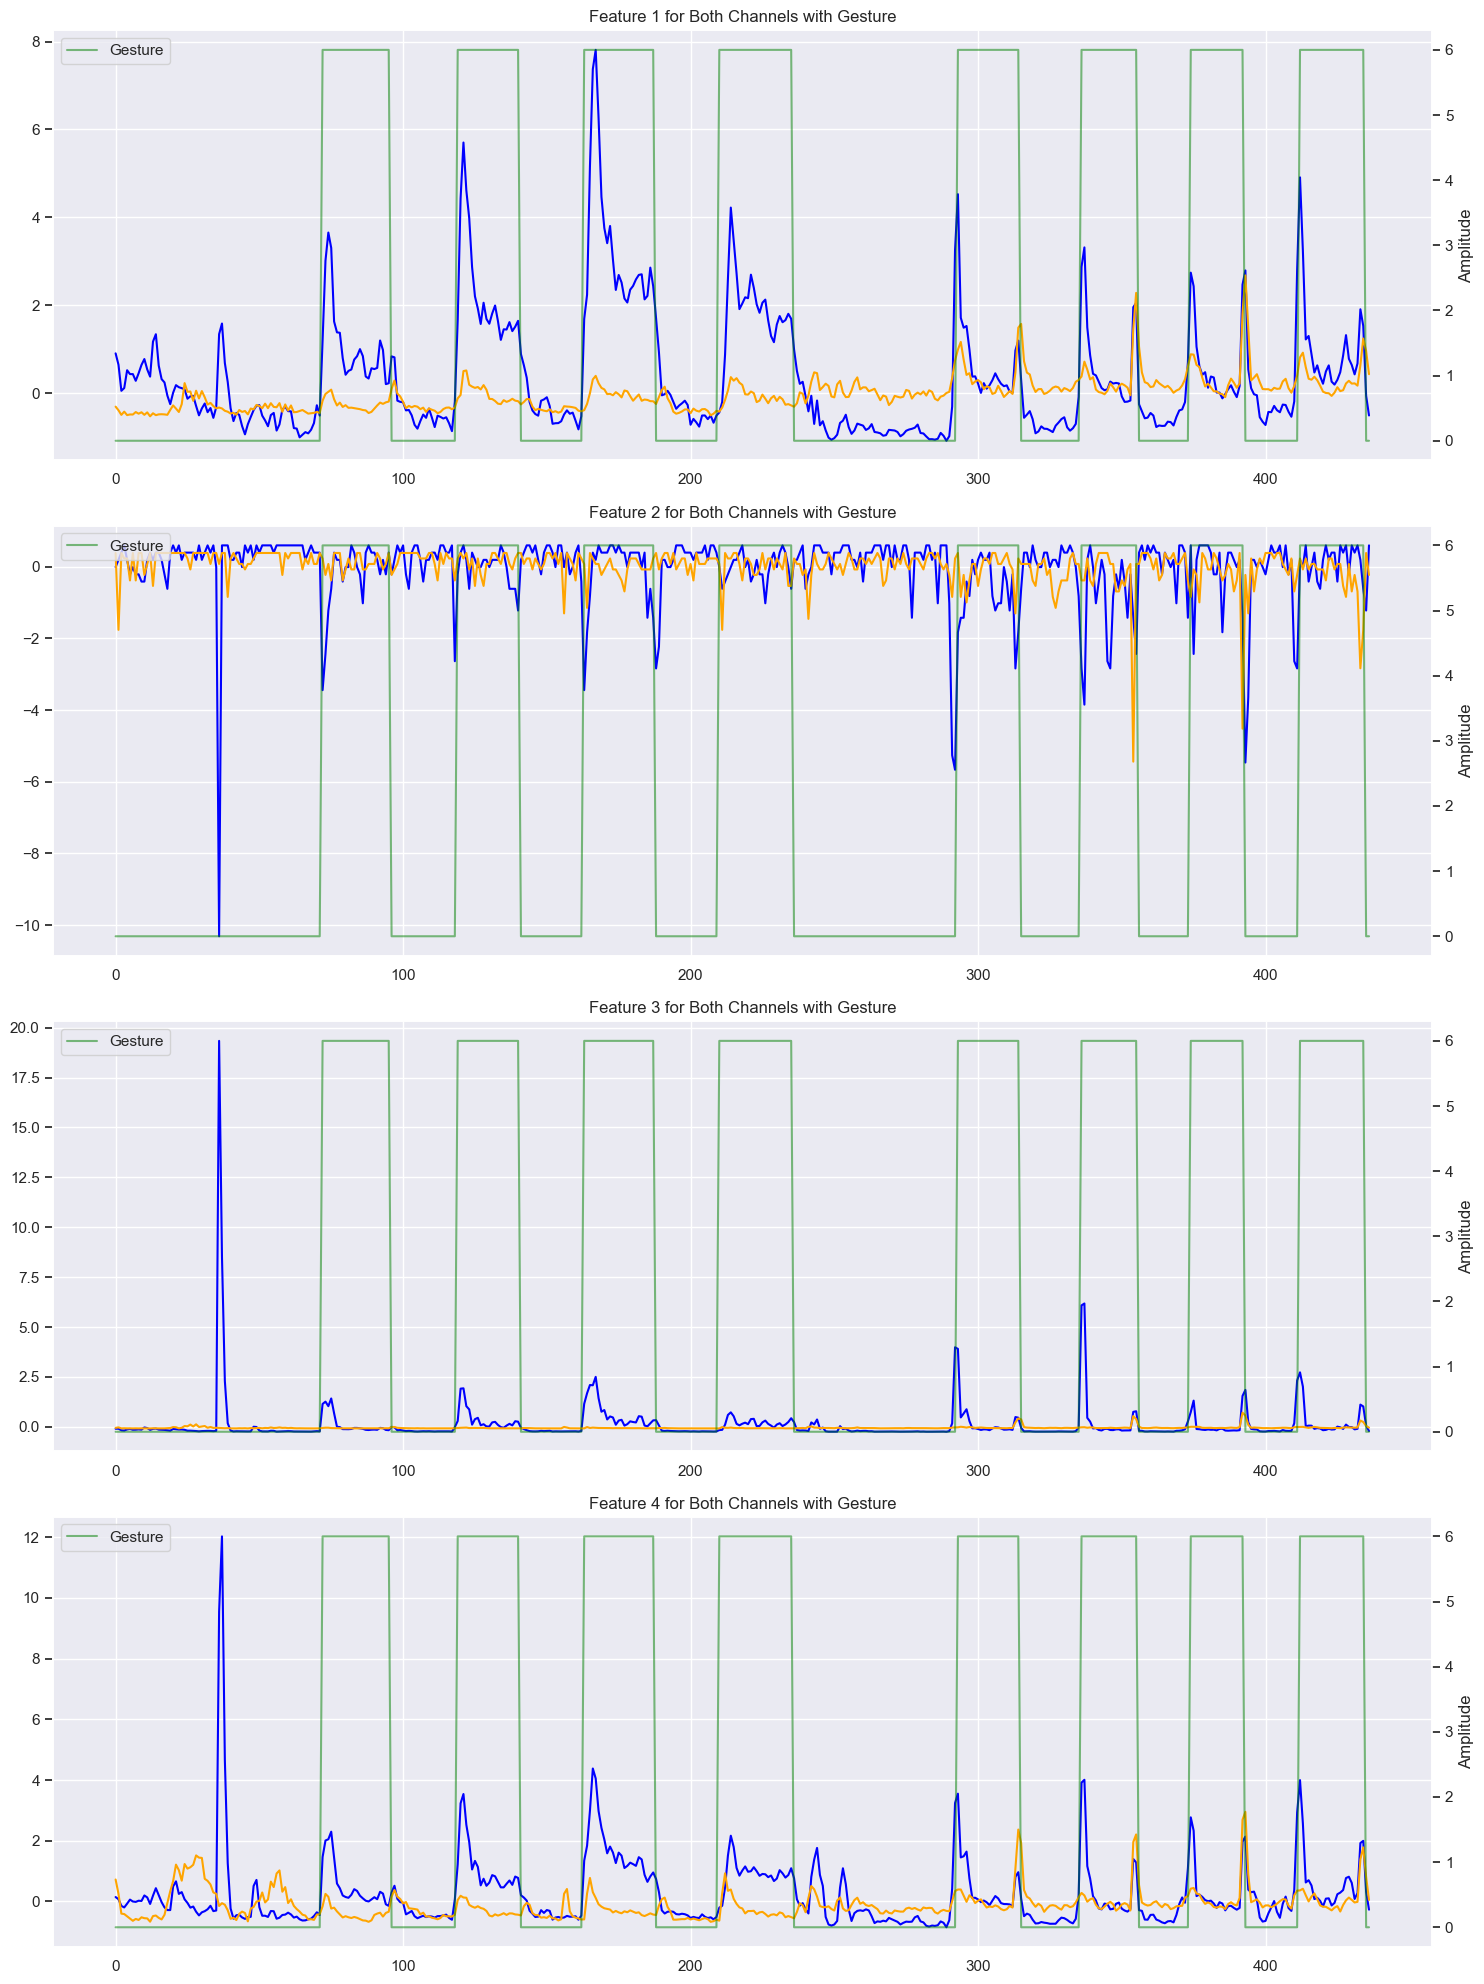

In [173]:
# Plot all features for testing data with 'Gesture' in the background
num_features = testing_features.shape[1] // 2  # Assuming equal features for both channels
plt.figure(figsize=(15, 5 * num_features))

for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(testing_features[:, i], label=f'Feature {i + 1} (Channel 1)', color='blue')
    plt.plot(testing_features[:, i + num_features], label=f'Feature {i + 1} (Channel 2)', color='orange')

    # Add Gesture in the background with its own scale
    plt.twinx()  # Create a second y-axis
    plt.plot(testing_labels, label='Gesture', color='green', alpha=0.5)
    plt.ylabel('Gesture')

    # Add titles and labels
    plt.title(f'Feature {i + 1} for Both Channels with Gesture')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left')
    plt.grid()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

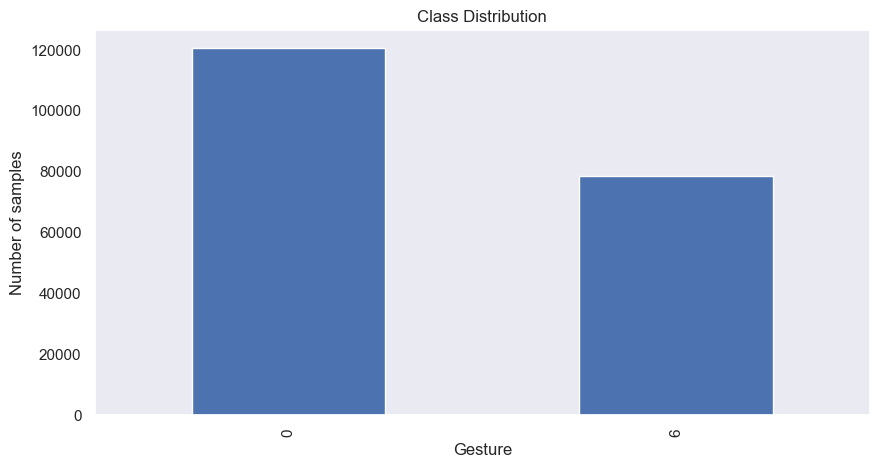

In [174]:
# Count each label
label_counts = train_data['Gesture'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Gesture")
plt.ylabel("Number of samples")
plt.grid()
plt.show()

## Model

In [175]:
# Define the Random Forest model
rf = RandomForestClassifier()

# Hyperparameter optimization using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'n_estimators': [50],
    # 'max_depth': [10],
    # 'min_samples_split': [2],
    # 'min_samples_leaf': [2],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(training_features, training_labels)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(training_features, training_labels)


Fitting 2 folds for each of 81 candidates, totalling 162 fits
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5)

Accuracy score: 0.9130434782608695
Recall score: 0.9112137430939227
F1 score: 0.9105472958414136


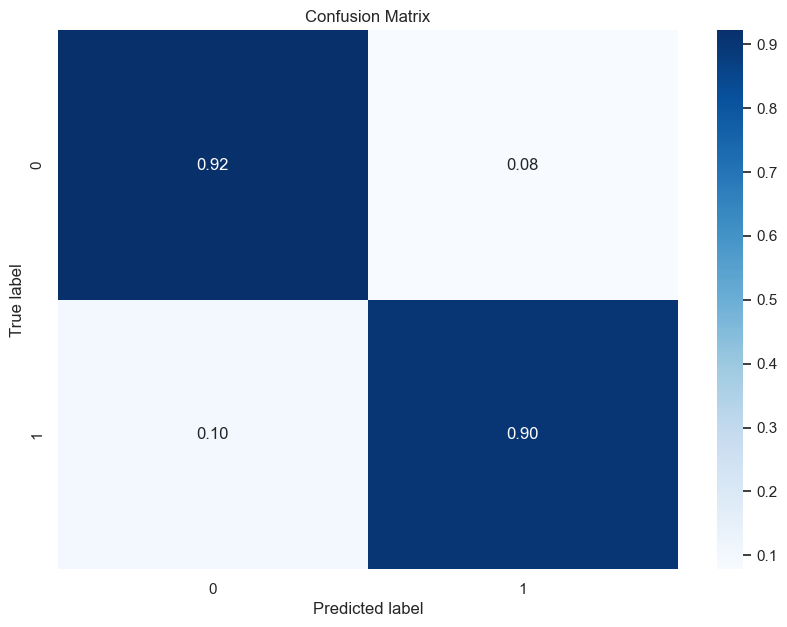

In [176]:
# Evaluate the model
y_pred = best_rf.predict(testing_features)
accuracy = accuracy_score(testing_labels, y_pred)
print(f"Accuracy score: {accuracy}")
print(f"Recall score: {recall_score(testing_labels, y_pred, average='macro')}")
print(f"F1 score: {f1_score(testing_labels, y_pred, average='macro')}")

tst_l = [l.astype('str') for l in testing_labels]
pred_l = [l.astype('str') for l in y_pred]

# Confusion matrix
confmat = confusion_matrix(tst_l, pred_l, labels=[i.astype('str') for i in np.unique(testing_labels)], normalize='true')
plt.figure(figsize=(10, 7))
sns.heatmap(confmat, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

In [177]:
print([i.astype('str') for i in np.unique(testing_labels)])

['0', '6']


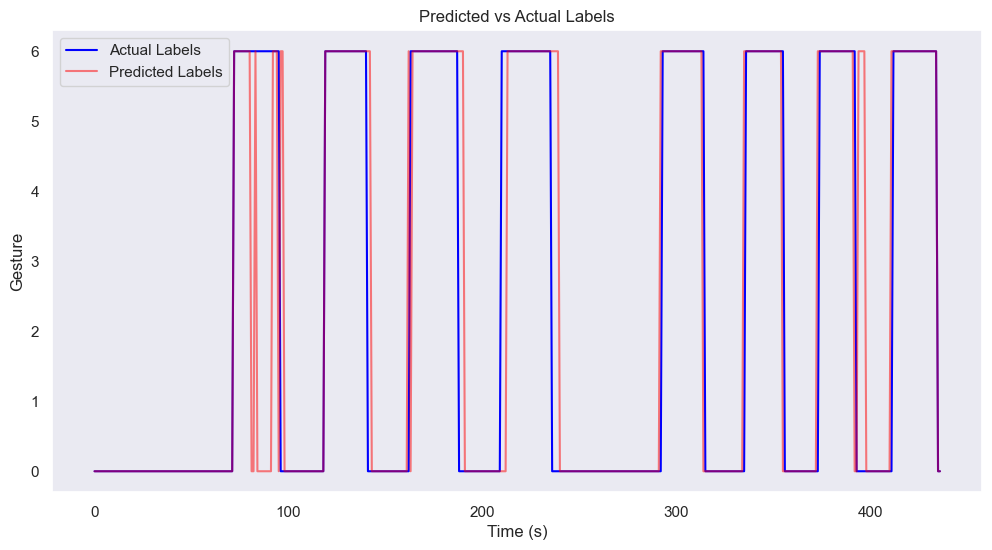

In [178]:
# Plot predicted VS actual labels vs time
plt.figure(figsize=(12, 6))  # Adjust the figure size
plt.plot(testing_labels, label='Actual Labels', color='blue')
plt.plot(y_pred, label='Predicted Labels', color='red', alpha=0.5)
plt.title('Predicted vs Actual Labels')
plt.xlabel('Time (s)')
plt.ylabel('Gesture')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# b) 2 phases detection : gesture detection + type of gesture classification

In [179]:
good_trials = [0, 5, 7, 9, 10, 11, 12, 13] # Good trials to keep (12 ?)
bad_trials = [1, 2, 3, 4, 6, 8]

list_npulse_cleaned_data_b = list_npulse_cleaned_data.copy()

# New column 'Rest' : 0 if 'Rest' else 1
for i, data in enumerate(list_npulse_cleaned_data_b):
    list_npulse_cleaned_data_b[i]['Rest'] = np.where(data['Gesture'] == 0, 0, 1)

# Select good trials
list_npulse_good_cleaned_data = [list_npulse_cleaned_data_b[i] for i in good_trials]
# list_npulse_good_cleaned_data = list_npulse_cleaned_data_b.copy()

IndexError: list index out of range

In [ ]:
list_npulse_good_cleaned_data[0].head(5)  # Display the first 5 rows of the first file

Timestamp  Channel1   Channel2  Gesture  Rest
0      0.161 -4.085004 -23.157127        0     0
1      0.162 -4.901003 -31.700797        0     0
2      0.163 -4.314087 -32.439293        0     0
3      0.164 -4.134775 -37.256296        0     0
4      0.165 -4.632015 -38.458605        0     0

## Training, testing data

In [ ]:
# Divide the data into training and testing sets
dataset_size = len(list_npulse_good_cleaned_data)


test_size = int(dataset_size * 0.2)  # 20% for testing
train_size = dataset_size - test_size  # 80% for training

# Take random Files from the list
# train_files = random.sample(list_npulse_cleaned_data, k=train_size)  # Randomly sample without replacement
# test_files = [file for file in list_npulse_cleaned_data if file not in train_files]
train_files_id = random.sample(range(dataset_size), k=train_size)
test_files_id = [file for file in range(dataset_size) if file not in train_files_id]

print(f"Train files: {train_files_id}")
print(f"Test files: {test_files_id}")

# Concatenate the dataframes
train_data = pd.concat([list_npulse_good_cleaned_data[i] for i in train_files_id], ignore_index=True)
test_data = pd.concat([list_npulse_good_cleaned_data[i] for i in test_files_id], ignore_index=True)

print(f"Train data shape: {train_data.head()}")
print(f"Test data shape: {test_data.head()}")

Train files: [5, 2, 0, 7, 1, 6, 3]
Test files: [4]
Train data shape:    Timestamp  Channel1   Channel2  Gesture  Rest
0      0.149 -2.557648  15.267994        0     0
1      0.150 -3.754541  20.109506        0     0
2      0.151 -2.381251  30.977657        0     0
3      0.152 -2.543856  28.587961        0     0
4      0.153 -1.532082  27.213811        0     0
Test data shape:    Timestamp  Channel1   Channel2  Gesture  Rest
0      0.153  6.324121 -24.043367        0     0
1      0.154  7.496065 -36.967092        0     0
2      0.155  6.788157 -38.803827        0     0
3      0.156  7.868580 -42.978059        0     0
4      0.157  8.553357 -40.517048        0     0


## Features

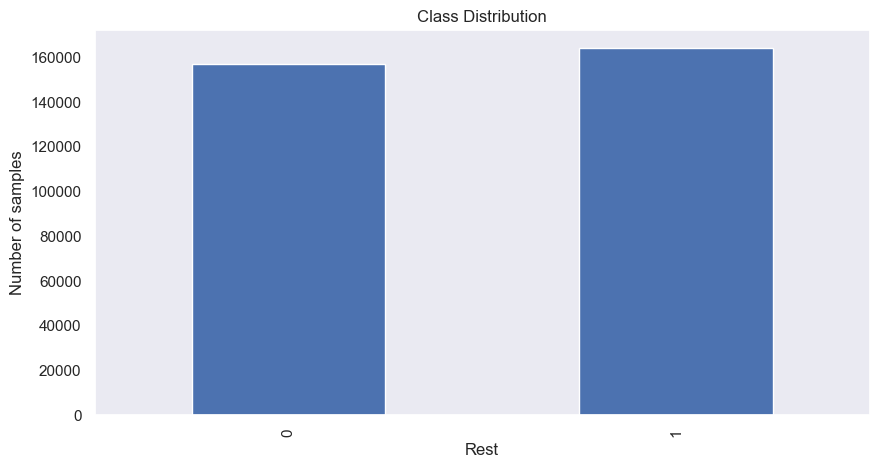

In [ ]:
# balanced_train_data = balance_rest(train_data, label_col='Gesture', rest_label=0, target_rest_ratio=0.4)
balanced_train_data = train_data.copy()

# Count each label
label_counts = balanced_train_data['Rest'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Rest")
plt.ylabel("Number of samples")
plt.grid()
plt.show()

In [ ]:
time_window = 600 # 200 ms
time_sliding = 300 # 100 ms

fs = 1000 # Sampling frequency in Hz

window = int(time_window * fs / 1000) # Convert to samples
step = int(time_sliding * fs / 1000) # Convert to samples

# All features
# features_selected = [total_power, mav, rms, mean_freq, median_freq, peak_freq, maxav, std, wl, ssc]
features_selected = [wl, rms, ssc, median_freq, total_power]

# Suggested features
features_selected = [zc, ssc, wl, log_det, wamp, var, mav, rms]
features_selected = [wl, wamp, var, rms]

# All features
features_selected = [
    total_power, mav, std, var, maxav, rms, wl, ssc, zc, log_det, wamp,
    mean_freq, median_freq, peak_freq
]

training_features, training_labels = extract_features_and_labels(balanced_train_data, features_selected, label_column='Rest', window=window, step_size=step)
testing_features, testing_labels = extract_features_and_labels(test_data, features_selected, label_column='Rest', window=window, step_size=step)

In [ ]:
print(training_features.shape, training_labels.shape, testing_features.shape, testing_labels.shape)

# features names
features_names = []
for i in range(2):
    for feat in features_selected:
        features_names.append(f"{feat.__name__}_ch{i+1}")

print(features_names)

(1067, 28) (1067,) (148, 28) (148,)
['total_power_ch1', 'mav_ch1', 'std_ch1', 'var_ch1', 'maxav_ch1', 'rms_ch1', 'wl_ch1', 'ssc_ch1', 'zc_ch1', 'log_det_ch1', 'willison_ch1', 'mean_freq_ch1', 'median_freq_ch1', 'peak_freq_ch1', 'total_power_ch2', 'mav_ch2', 'std_ch2', 'var_ch2', 'maxav_ch2', 'rms_ch2', 'wl_ch2', 'ssc_ch2', 'zc_ch2', 'log_det_ch2', 'willison_ch2', 'mean_freq_ch2', 'median_freq_ch2', 'peak_freq_ch2']


In [ ]:
# Feature normalization
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
testing_features = scaler.transform(testing_features)  # Use the same scaler for testing data

In [ ]:
# # Select best features
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# training_features = sel.fit_transform(training_features)
# testing_features = sel.transform(testing_features)

sel2 = SelectPercentile(percentile=25)
# training_features = sel2.fit_transform(training_features, training_labels, feature_names_in_ = features_names)
training_features = sel2.fit_transform(training_features, training_labels)
testing_features = sel2.transform(testing_features)

c:\Users\willi\miniconda3\envs\npulse_emg-decoding\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 8 13 22 27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\willi\miniconda3\envs\npulse_emg-decoding\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
print(sel2.get_feature_names_out(features_names))
print(sel2.scores_)
print(sel2.pvalues_)

print(training_features.shape, testing_features.shape)

['mav_ch2' 'std_ch2' 'var_ch2' 'maxav_ch2' 'rms_ch2' 'wl_ch2' 'ssc_ch2']
[3.16778513e-04 3.58128283e-01 7.18731311e-01 2.22233863e-02
 1.16341260e+00 4.67872816e-01 3.38534241e+00 5.59087236e+00
            nan 2.88392876e-01 2.46594608e+00 1.14539684e+00
 4.99853616e-01            nan 4.00438044e+00 7.02996932e+00
 9.38480173e+00 7.96225069e+00 9.31463983e+00 8.10726262e+00
 6.71512631e+00 8.72799076e+00            nan 5.65088057e+00
 5.93953265e+00 5.04199185e-01 6.49109702e+00            nan]
[0.98580312 0.54967483 0.39675086 0.88152259 0.28100315 0.49411621
 0.06605667 0.0182329         nan 0.59136443 0.11663467 0.28475732
 0.47971911        nan 0.04563557 0.00813468 0.0022429  0.0048651
 0.00232964 0.00449353 0.0096906  0.00320252        nan 0.01762245
 0.01496781 0.47781627 0.01098118        nan]
(1067, 7) (148, 7)


<Figure size 1500x1500 with 0 Axes>

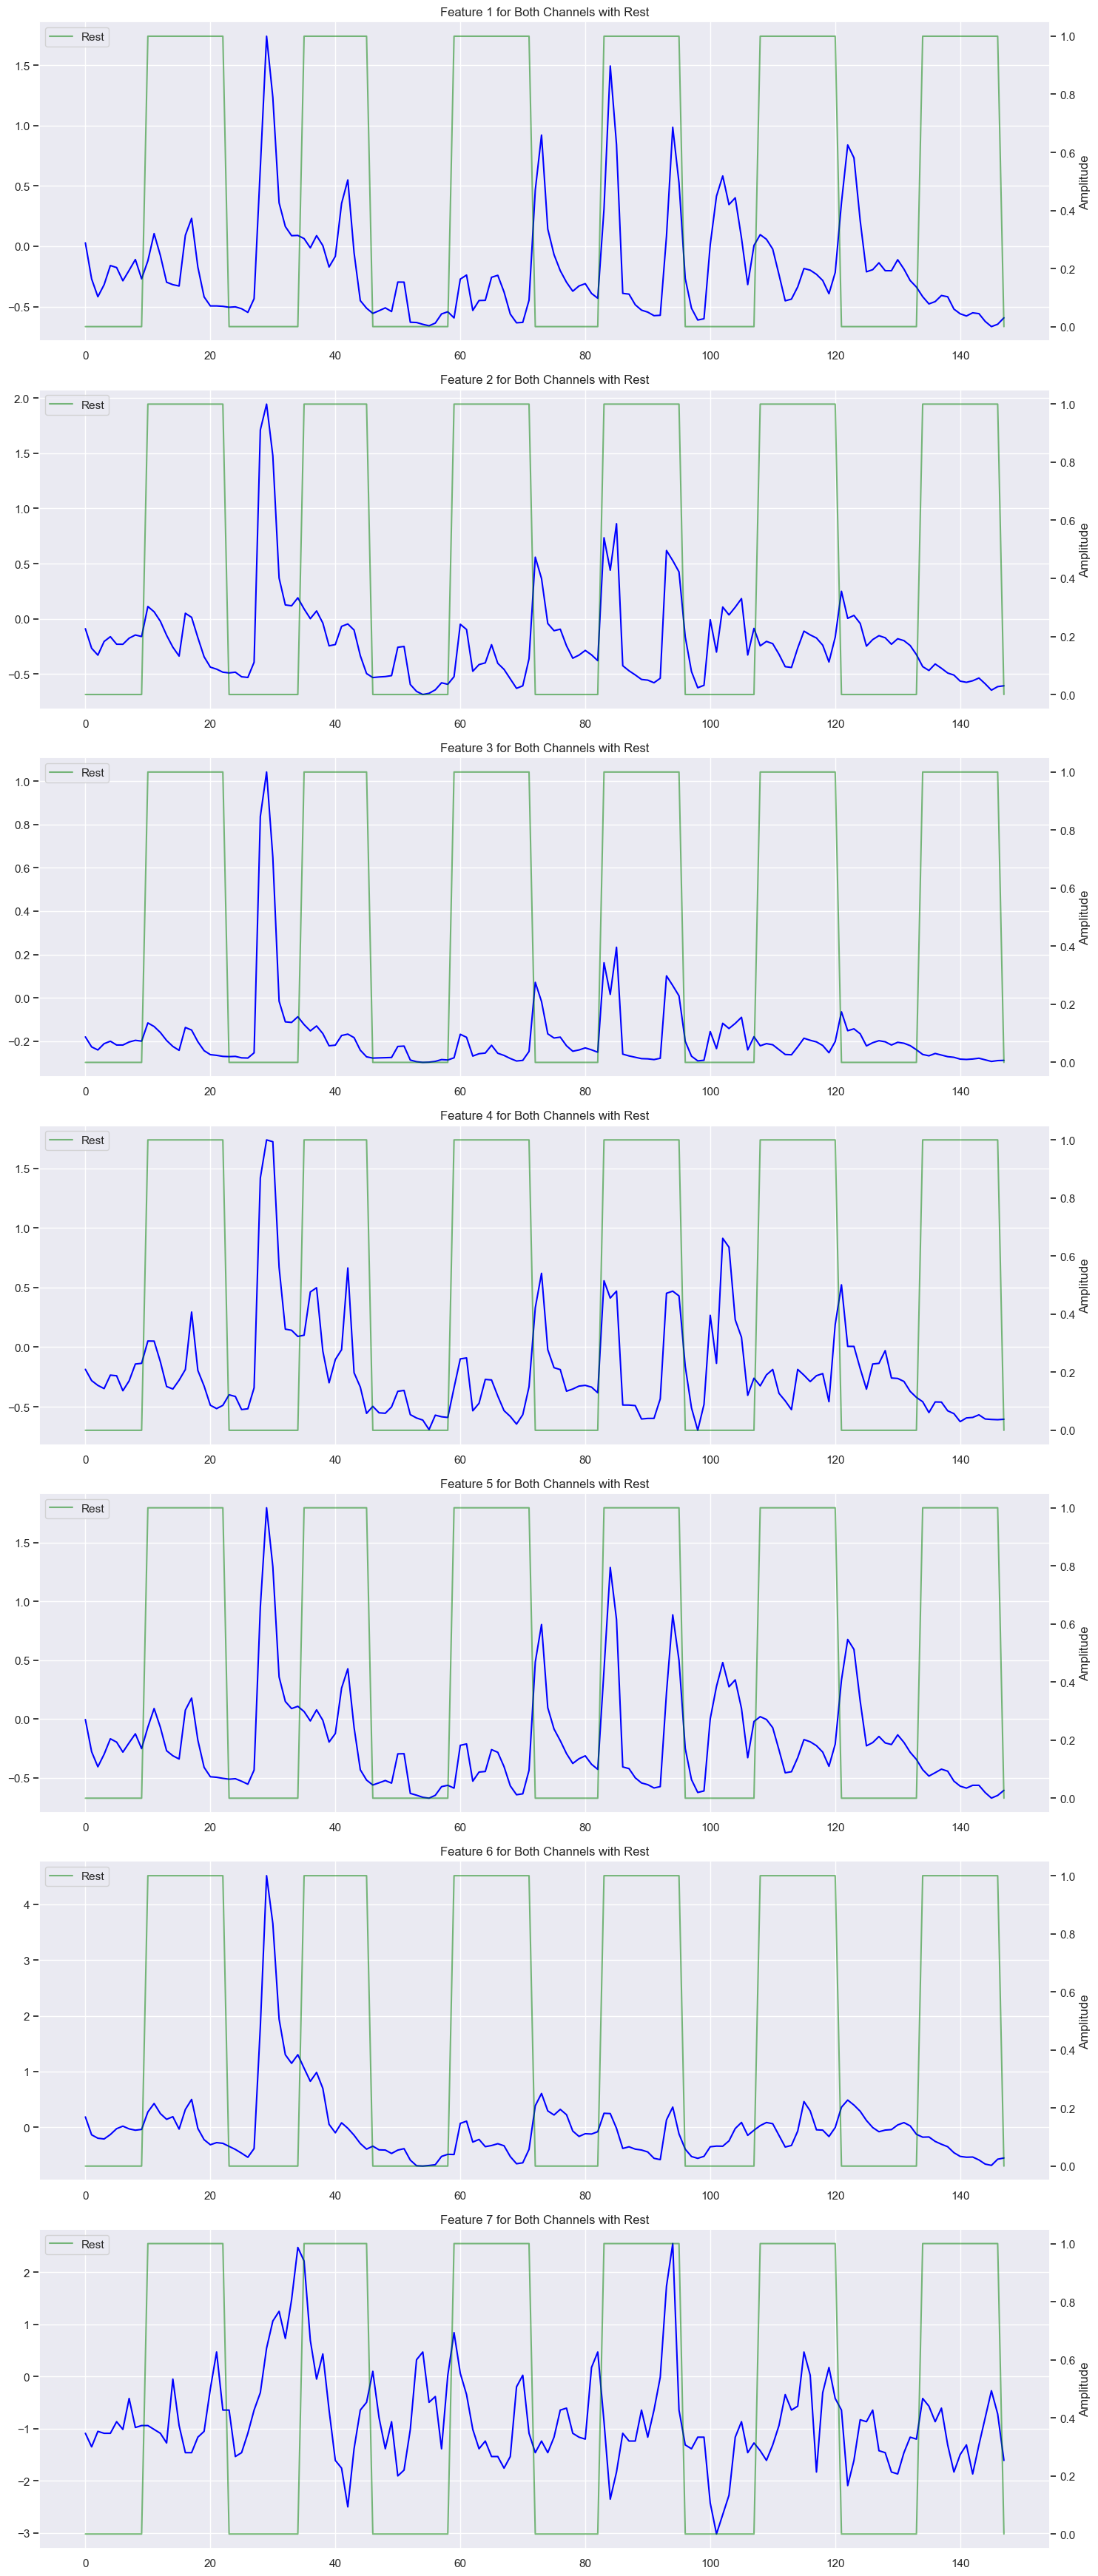

In [ ]:
# Plot all features for testing data with 'Gesture' in the background
# num_features = testing_features.shape[1] // 2  # Assuming equal features for both channels
# plt.figure(figsize=(15, 5 * num_features))

num_features = testing_features.shape[1]
plt.figure(figsize=(15, 5 * num_features))

for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(testing_features[:, i], label=f'Feature {i + 1} (Channel 1)', color='blue')
    # plt.plot(testing_features[:, i + num_features], label=f'Feature {i + 1} (Channel 2)', color='orange')

    # Add Gesture in the background with its own scale
    plt.twinx()  # Create a second y-axis
    plt.plot(testing_labels, label='Rest', color='green', alpha=0.5)
    plt.ylabel('Rest')

    # Add titles and labels
    plt.title(f'Feature {i + 1} for Both Channels with Rest')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left')
    plt.grid()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

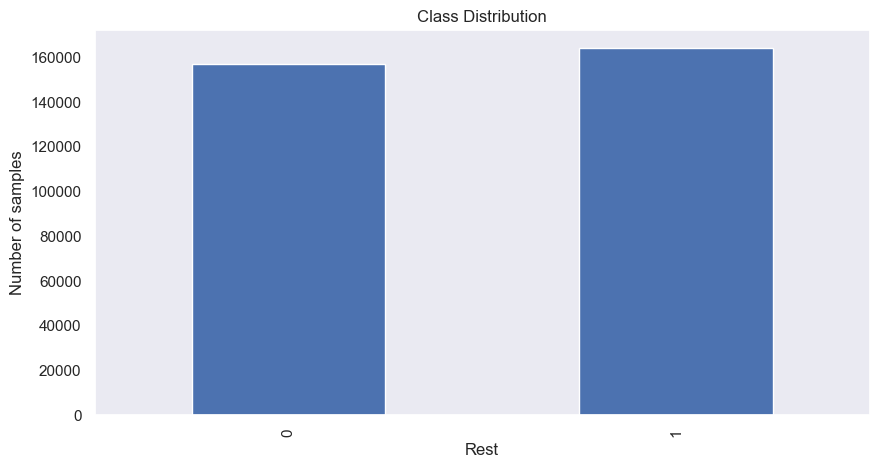

In [ ]:
# Count each label
label_counts = train_data['Rest'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Rest")
plt.ylabel("Number of samples")
plt.grid()
plt.show()

## Model

In [ ]:
# Define the Random Forest model
rf = RandomForestClassifier()

# Hyperparameter optimization using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'n_estimators': [50],
    # 'max_depth': [10],
    # 'min_samples_split': [2],
    # 'min_samples_leaf': [2],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(training_features, training_labels)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(training_features, training_labels)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(n_estimators=200)

Accuracy score: 0.5945945945945946
Recall score: 0.5935672514619883
F1 score: 0.5934065934065935


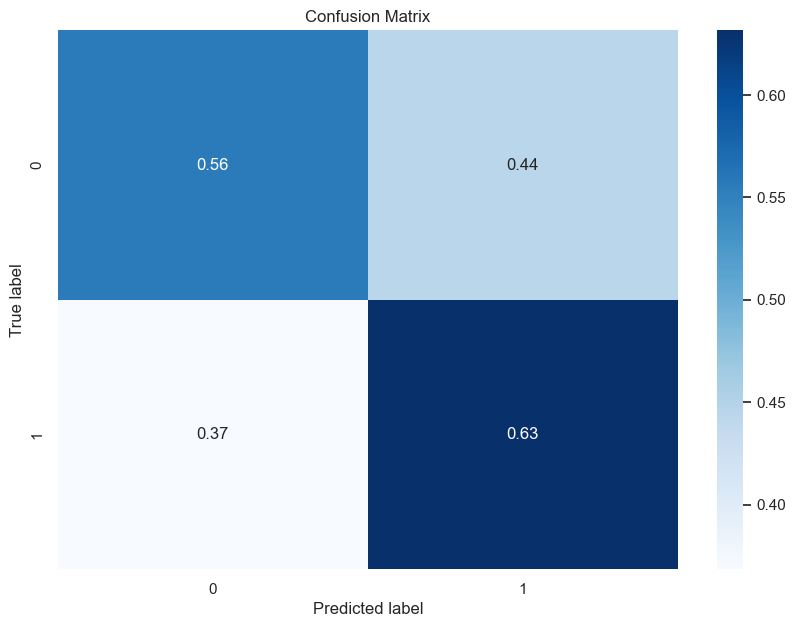

Explained Variance Score: [-0.61988304]


In [ ]:
# Evaluate the model
y_pred = best_rf.predict(testing_features)
accuracy = accuracy_score(testing_labels, y_pred)
print(f"Accuracy score: {accuracy}")
print(f"Recall score: {recall_score(testing_labels, y_pred, average='macro')}")
print(f"F1 score: {f1_score(testing_labels, y_pred, average='macro')}")

tst_l = [l.astype('str') for l in testing_labels]
pred_l = [l.astype('str') for l in y_pred]

# Confusion matrix
confmat = confusion_matrix(tst_l, pred_l, labels=[i.astype('str') for i in np.unique(testing_labels)], normalize='true')
plt.figure(figsize=(10, 7))
sns.heatmap(confmat, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# Explained variance score for features
explained_variance = explained_variance_score(testing_labels, y_pred, multioutput='raw_values')
print(f"Explained Variance Score: {explained_variance}")

In [ ]:
print([i.astype('str') for i in np.unique(testing_labels)])

['0', '1']


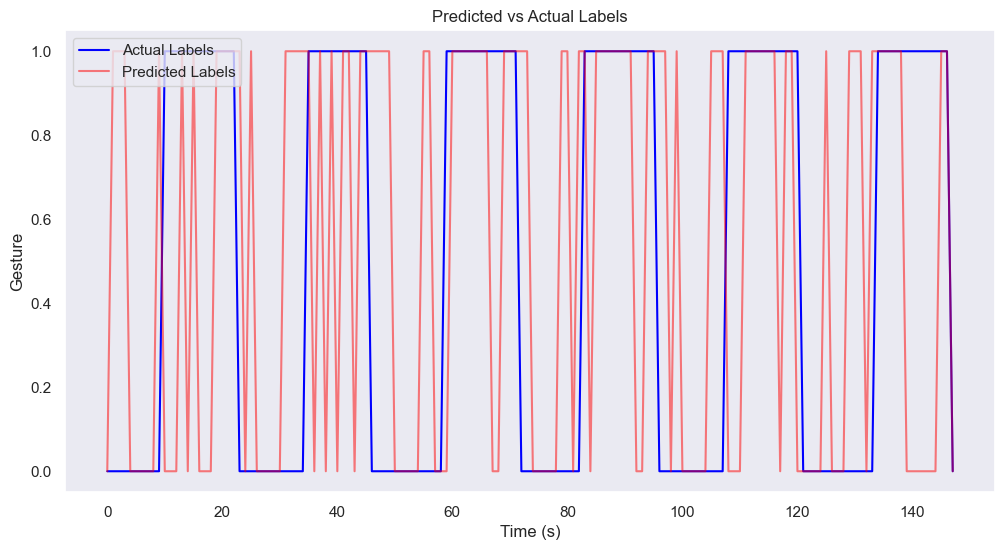

In [ ]:
# Plot predicted VS actual labels vs time
plt.figure(figsize=(12, 6))  # Adjust the figure size
plt.plot(testing_labels, label='Actual Labels', color='blue')
plt.plot(y_pred, label='Predicted Labels', color='red', alpha=0.5)
plt.title('Predicted vs Actual Labels')
plt.xlabel('Time (s)')
plt.ylabel('Gesture')
plt.legend(loc='upper left')
plt.grid()
plt.show()